In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS, BRAIN_AREAS

epoch_key = ('bon', 3, 2)

In [4]:
import itertools
from src.load_data import load_data

speed_metric='linear_speed'

data_types = set(itertools.chain(*USE_LIKELIHOODS.values()))
data = load_data(epoch_key, ANIMALS, SAMPLING_FREQUENCY,
                 BRAIN_AREAS, speed_metric)

INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Finding multiunit high synchrony events...
INFO:src.load_data:Finding ripple times...


In [5]:
from replay_identification import ReplayDetector

position_metric = 'linear_position2'

replay_detector = ReplayDetector(spike_model_knot_spacing=10, place_bin_size=2.0, replay_speed=2000,
                                 replay_state_transition_penalty=1e-5, movement_std=0.05,
                                 movement_state_transition_type='w_track_1D_random_walk')
replay_detector.fit(
    is_replay=data['is_ripple'], speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric], spikes=data['spikes'],
    track_labels=data['position_info'].arm_name.values)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...


INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
        lfp_model_kwargs={'n_components': 10, 'max_iter': 200, 'tol': 1e-06},
        movement_state_transition_type='w_track_1D_random_walk',
        movement_std=0.05,
        multiunit_density_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
        multiunit_model_kwargs={'n_components': 30, 'max_iter': 200, 'tol': 1e-06},
        multiunit_occupancy_kwargs={'bandwidth': 2},
        multiunit_occupancy_model=<class 'sklearn.neighbors.kde.KernelDensity'>,
        n_place_bins=None, place_bin_size=2.0, replay_speed=2000,
        replay_state_transition_penalty=1e-05, speed_knots=None,
        speed_threshold=4.0, spike_model_knot_spacing=10,
        spike_model_penalty=0.1)

In [6]:
detector_results = replay_detector.predict(
    speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=data['power'],
    spikes=data['spikes'],
    time=data['position_info'].index,
    use_likelihoods=['spikes'],
    use_smoother=True)

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


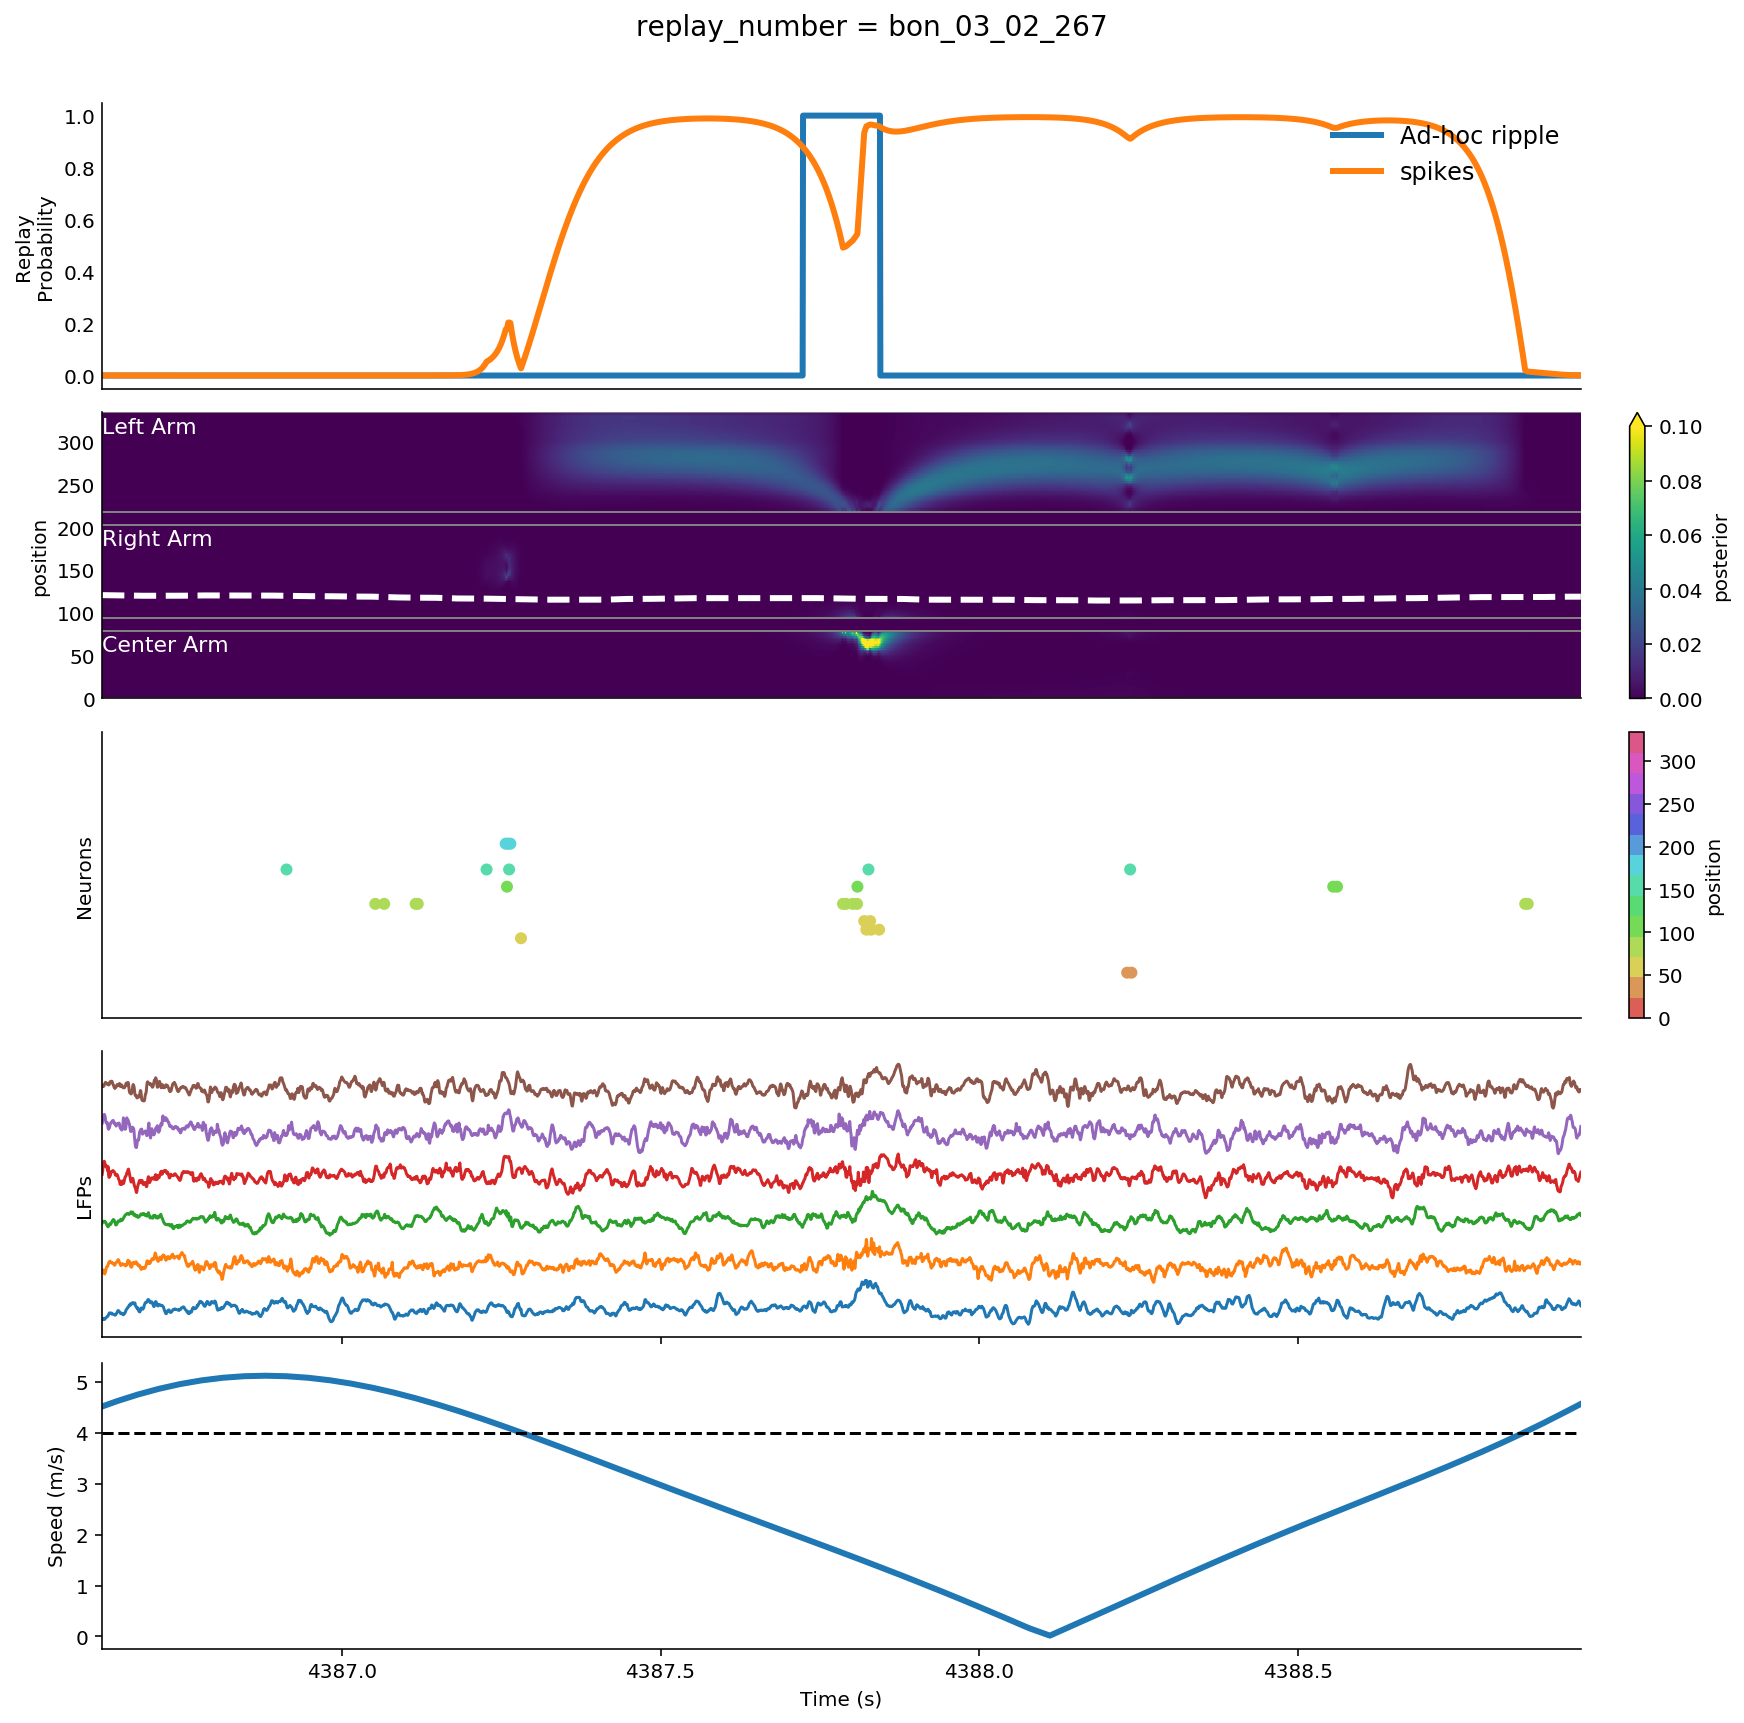

In [7]:
from src.visualization import plot_replay_with_data

replay_number = 267

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results,
                      show_data_types=['lfps', 'spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric, offset=pd.Timedelta(1.100, 's'));

In [8]:
detector_results_no_smoother = replay_detector.predict(
    speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=data['power'],
    spikes=data['spikes'],
    time=data['position_info'].index,
    use_likelihoods=['spikes'],
    use_smoother=False)

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


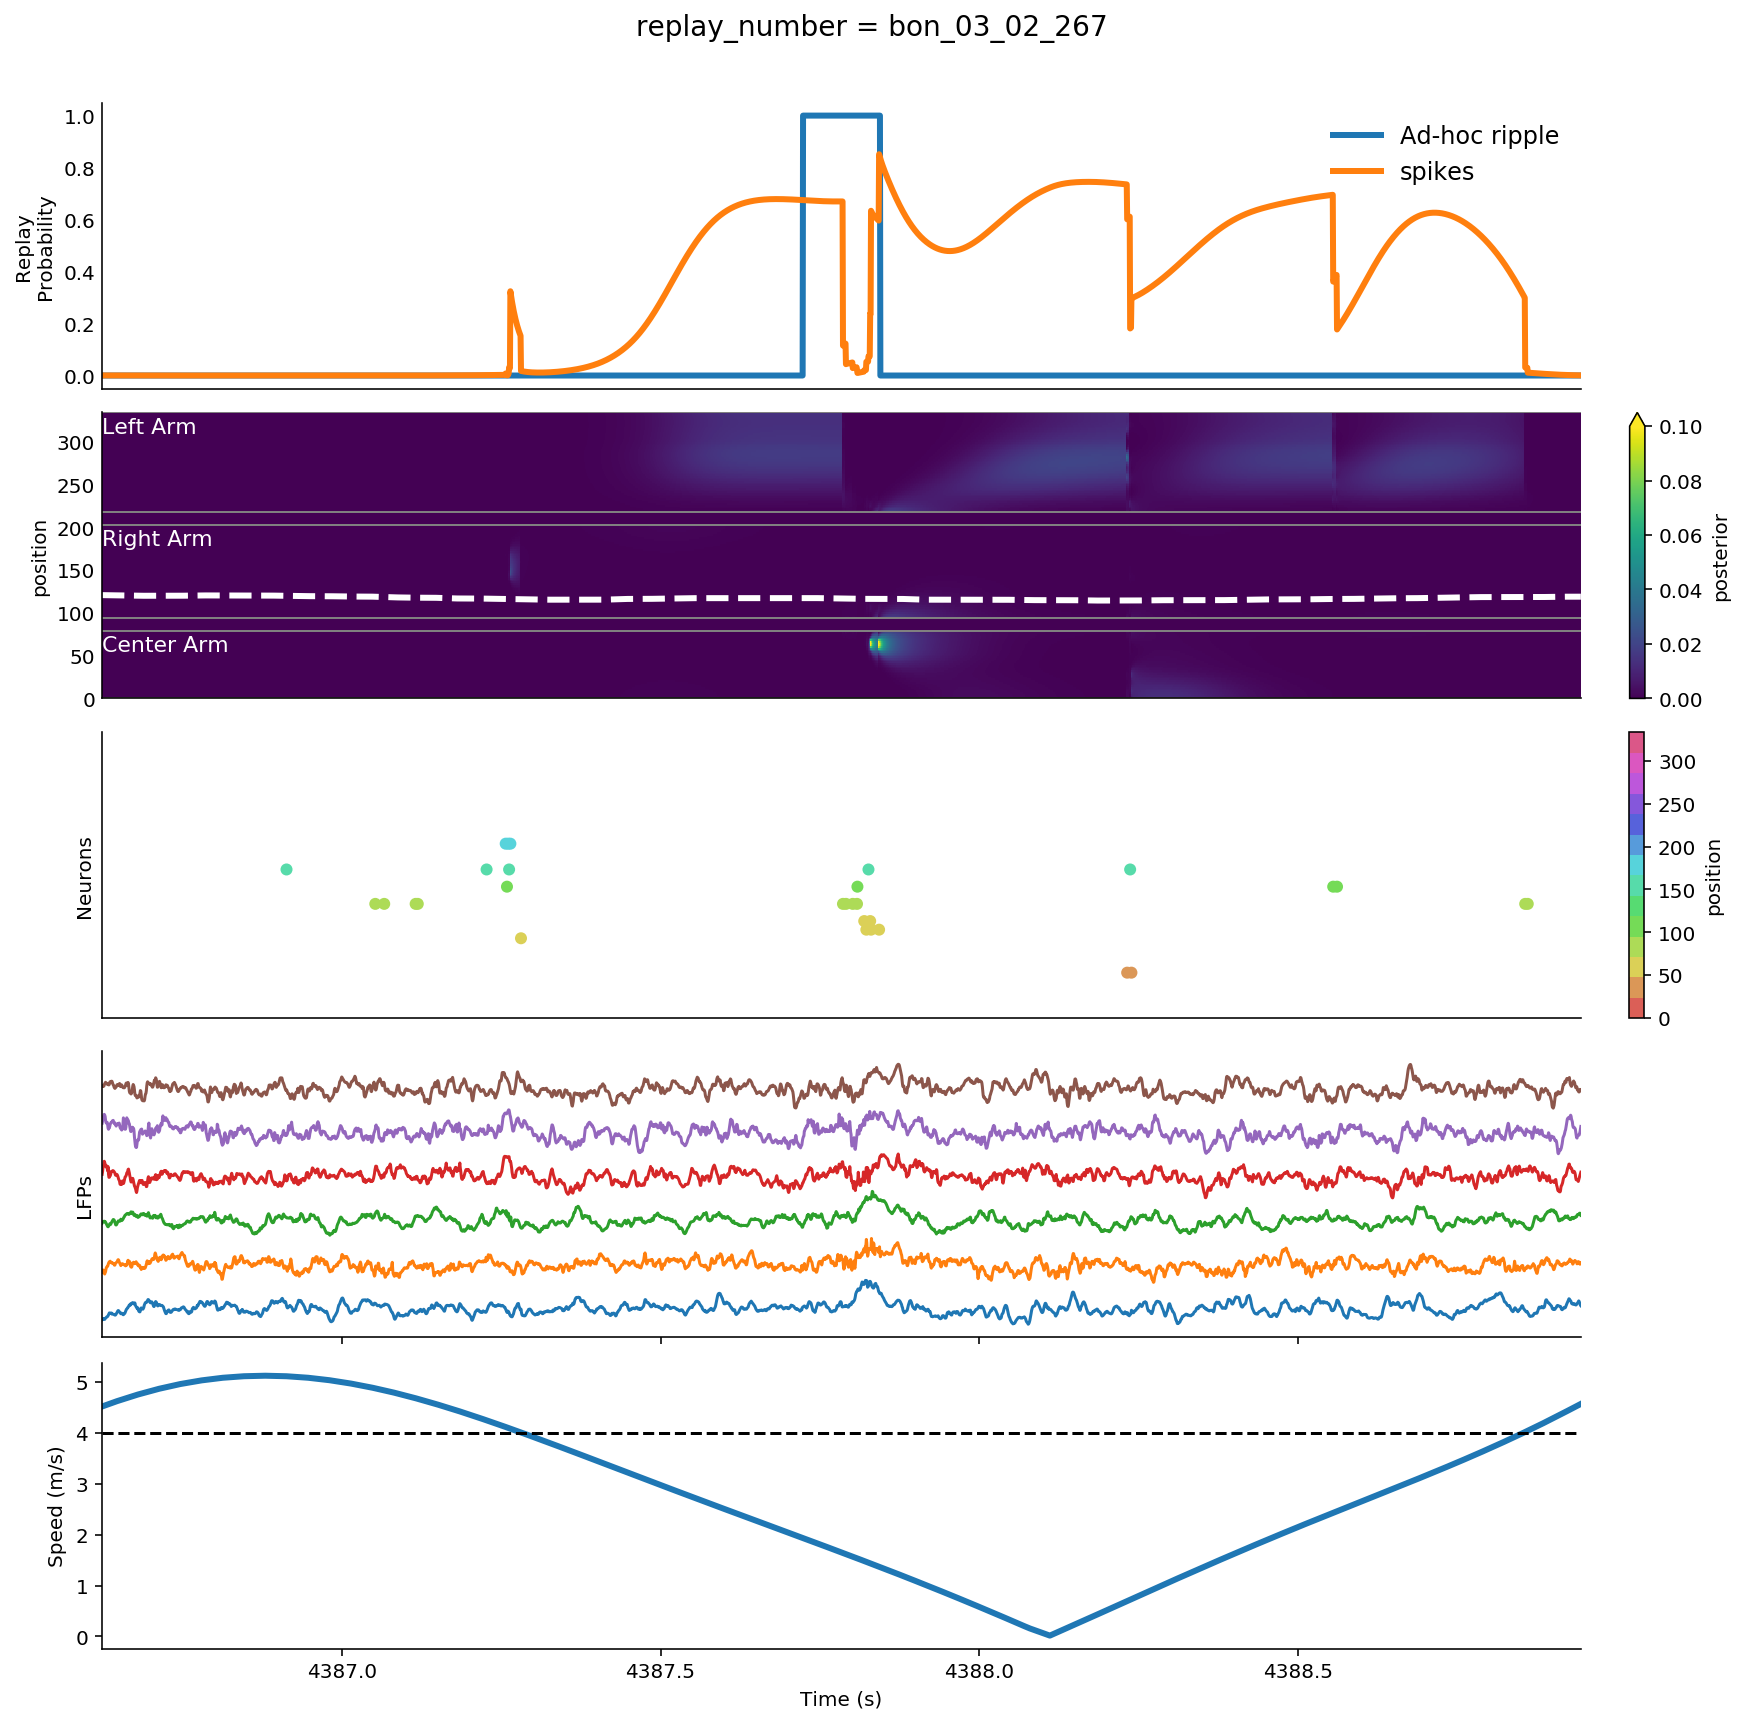

In [9]:
from src.visualization import plot_replay_with_data

replay_number = 267

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['lfps', 'spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric, offset=pd.Timedelta(1.100, 's'));

In [14]:
from ipywidgets import interact
from src.visualization import plot_replay_spiking_ordered_by_place_fields

import seaborn as sns

offset = pd.Timedelta(1.100, 's')
replay_number = 267

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = detector_results_no_smoother.sel(time=slice(start_time, end_time)).time
segment_ind = np.nonzero(detector_results_no_smoother.time.isin(segment_time.time).values)[0]


@interact(time=(segment_ind[0], segment_ind[-1]))
def plot_likelihood(time=segment_ind[0]):
    fig, axes = plt.subplots(2, 3, figsize=(12, 4), constrained_layout=True)

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 0]))
    axes[0, 0].set_title('No Replay')
    axes[0, 0].set_xlabel('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 1]))
    axes[0, 1].set_title('Replay')
    axes[0, 1].set_xlabel('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 0]))
    axes[1, 0].set_title('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 1]))
    axes[1, 1].set_ylim((0, 0.05))
    axes[1, 1].set_title('')
   
    replay_probability = (detector_results_no_smoother
     .isel(time=time)
     .replay_probability.values)
    if replay_probability >= 0.08:
        axes[1, 1].set_ylim((0, 0.15))
    else:
        axes[1, 1].set_ylim((0, 0.0015))
    
    (detector_results_no_smoother
     .sel(time=slice(start_time, end_time))
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .replay_probability.plot(x='time', ax=axes[0, -1]))
    
    place_bin_centers = replay_detector.place_bin_centers_.squeeze(axis=-1)
    place_bin_edges = replay_detector.place_bin_edges_.squeeze(axis=-1)
    is_track = (np.histogram(data['position_info'][position_metric],
                             bins=place_bin_edges)[0] > 0)
    place_fields = (replay_detector
                    ._spiking_likelihood
                    .keywords['place_conditional_intensity'].T
                    * 1500)
    place_fields[:, ~is_track] = 0.0
    spikes = data['spikes'].loc[start_time:end_time]
    
    plot_replay_spiking_ordered_by_place_fields(
        spikes.values, place_fields, place_bin_centers, ax=axes[-1, -1],
        time=spikes.index / np.timedelta64(1, 's'))
    t = detector_results_no_smoother.isel(time=time).time.values / np.timedelta64(1, 's')
    axes[-1, -1].axvline(t, color='black')
    axes[0, -1].axvline(t, color='black')
    axes[-1, -1].set_yticks([])
    t = spikes.index / np.timedelta64(1, 's')
    axes[-1, -1].set_xlim((t[0], t[-1]))
    axes[0, -1].set_xlim((t[0], t[-1]))

    sns.despine()


interactive(children=(IntSlider(value=986397, description='time', max=989697, min=986397), Output()), _dom_cla…

In [ ]:
import os
from statsmodels.tsa.tsatools import lagmat
from tqdm.autonotebook import tqdm
from src.visualization import plot_replay_spiking_ordered_by_place_fields


def plot_likelihood(time, start_time, end_time, results, replay_detector,
                    data, replay_state_transition, position_metric='linear_position2'):
    fig, axes = plt.subplots(3, 3, figsize=(12, 6), constrained_layout=True)
    
    (results
     .sel(time=time, state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 0]))
    axes[0, 0].set_title('No Replay')
    axes[0, 0].set_xlabel('')

    (results
     .sel(time=time, state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 1]))
    axes[0, 1].set_title('Replay')
    axes[0, 1].set_xlabel('')

    (results
     .sel(time=time, state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 0]))
    axes[1, 0].set_title('')

    (results
     .sel(time=time, state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 1]))
    replay_probability = (results
     .sel(time=time)
     .replay_probability.values)
    if replay_probability >= 0.05:
        axes[1, 1].set_ylim((0, 0.15))
    else:
        axes[1, 1].set_ylim((0, 0.001))
    axes[1, 1].set_title('')
    
    (results
     .sel(time=slice(start_time, end_time))
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .replay_probability.plot(x='time', ax=axes[0, 2]))
    
    place_bin_centers = replay_detector.place_bin_centers_.squeeze(axis=-1)
    place_bin_edges = replay_detector.place_bin_edges_.squeeze(axis=-1)
    is_track = (np.histogram(data['position_info'][position_metric],
                             bins=place_bin_edges)[0] > 0)
    place_fields = (replay_detector
                    ._spiking_likelihood
                    .keywords['place_conditional_intensity'].T
                    * 1500)
    place_fields[:, ~is_track] = 0.0
    spikes = data['spikes'].loc[start_time:end_time]
    
    plot_replay_spiking_ordered_by_place_fields(
        spikes.values, place_fields, place_bin_centers, ax=axes[1, 2],
        time=spikes.index / np.timedelta64(1, 's'))
    t = results.sel(time=time).time.values / np.timedelta64(1, 's')
    axes[1, 2].axvline(t, color='black')
    axes[0, 2].axvline(t, color='black')
    axes[2, 2].axvline(t, color='black')
    axes[2, 0].axvline(t, color='black')
    axes[2, 1].axvline(t, color='black')
    axes[1, 2].set_yticks([])
    t = spikes.index / np.timedelta64(1, 's')
    axes[1, 2].set_xlim((t[0], t[-1]))
    axes[0, 2].set_xlim((t[0], t[-1]))
    axes[0, 1].axvline(data['position_info'][position_metric].loc[time],
                       color='black', zorder=0, linestyle='--')
    axes[1, 1].axvline(data['position_info'][position_metric].loc[time],
                       color='black', zorder=0, linestyle='--')
    axes[2, 2].plot(spikes.index / np.timedelta64(1, 's'),
                    data['position_info']['linear_speed'].loc[start_time:end_time].values)
    axes[2, 2].axhline(4, color='black', linestyle='--')
    axes[2, 2].set_xlim((t[0], t[-1]))
    
    (replay_state_transition
     .sel(time=slice(start_time, end_time), state='p(replay | no_previous_replay)')
     .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .plot(x='time', ax=axes[2, 0])
    )
    axes[2, 0].set_xlim((t[0], t[-1]))
    
    (replay_state_transition
     .sel(time=slice(start_time, end_time), state='p(replay | previous_replay)')
     .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .plot(x='time', ax=axes[2, 1])
    )
    axes[2, 1].set_xlim((t[0], t[-1]))
    sns.despine()
    cur_time = time / np.timedelta64(1, 's')
    plt.suptitle(f'time = {cur_time:.03f}')
    
    return fig


In [17]:
folder = 'temp'
os.makedirs(folder, exist_ok=True)

offset = pd.Timedelta(1.100, 's')
replay_number = 267

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = data['spikes'].loc[start_time:end_time].index

speed = data['position_info'][speed_metric]
speed = np.asarray(speed).squeeze()
lagged_speed = lagmat(speed, maxlag=1).squeeze()
replay_state_transition = replay_detector.replay_state_transition_(lagged_speed)
replay_state_transition = xr.DataArray(
    replay_state_transition, dims=['time', 'state'],
    coords={'state': ['p(replay | no_previous_replay)', 'p(replay | previous_replay)'],
            'time': detector_results_no_smoother.time})

for ind, time in enumerate(tqdm(segment_time)):
    fig = plot_likelihood(time, start_time, end_time, detector_results_no_smoother,
                          replay_detector, data, replay_state_transition)
    figure_name = (f'temp_{ind:04d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)

In [74]:
from ipywidgets import interact
from src.visualization import plot_replay_spiking_ordered_by_place_fields

import seaborn as sns

offset = pd.Timedelta(1.100, 's')
replay_number = 165

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = detector_results_no_smoother.sel(time=slice(start_time, end_time)).time
segment_ind = np.nonzero(detector_results_no_smoother.time.isin(segment_time.time).values)[0]


@interact(time=(segment_ind[0], segment_ind[-1]))
def plot_likelihood(time=segment_ind[0]):
    fig, axes = plt.subplots(2, 3, figsize=(12, 4), constrained_layout=True)

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 0]))
    axes[0, 0].set_title('No Replay')
    axes[0, 0].set_xlabel('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .likelihood.plot(x='position', ax=axes[0, 1]))
    axes[0, 1].set_title('Replay')
    axes[0, 1].set_xlabel('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='No Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 0]))
    axes[1, 0].set_title('')

    (detector_results_no_smoother
     .isel(time=time)
     .sel(state='Replay')
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .posterior.plot(x='position', ax=axes[1, 1]))
    axes[1, 1].set_ylim((0, 0.05))
    axes[1, 1].set_title('')
   
    replay_probability = (detector_results_no_smoother
     .isel(time=time)
     .replay_probability.values)
    if replay_probability >= 0.08:
        axes[1, 1].set_ylim((0, 0.15))
    else:
        axes[1, 1].set_ylim((0, 0.0015))
    
    (detector_results_no_smoother
     .sel(time=slice(start_time, end_time))
     .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
     .replay_probability.plot(x='time', ax=axes[0, -1]))
    
    place_bin_centers = replay_detector.place_bin_centers_.squeeze(axis=-1)
    place_bin_edges = replay_detector.place_bin_edges_.squeeze(axis=-1)
    is_track = (np.histogram(data['position_info'][position_metric],
                             bins=place_bin_edges)[0] > 0)
    place_fields = (replay_detector
                    ._spiking_likelihood
                    .keywords['place_conditional_intensity'].T
                    * 1500)
    place_fields[:, ~is_track] = 0.0
    spikes = data['spikes'].loc[start_time:end_time]
    
    plot_replay_spiking_ordered_by_place_fields(
        spikes.values, place_fields, place_bin_centers, ax=axes[-1, -1],
        time=spikes.index / np.timedelta64(1, 's'))
    t = detector_results_no_smoother.isel(time=time).time.values / np.timedelta64(1, 's')
    axes[-1, -1].axvline(t, color='black')
    axes[0, -1].axvline(t, color='black')
    axes[-1, -1].set_yticks([])
    t = spikes.index / np.timedelta64(1, 's')
    axes[-1, -1].set_xlim((t[0], t[-1]))
    axes[0, -1].set_xlim((t[0], t[-1]))
    axes[1, 0].set_ylim((0, 1))

    sns.despine()


interactive(children=(IntSlider(value=590854, description='time', max=594154, min=590854), Output()), _dom_cla…

KeyboardInterrupt: 

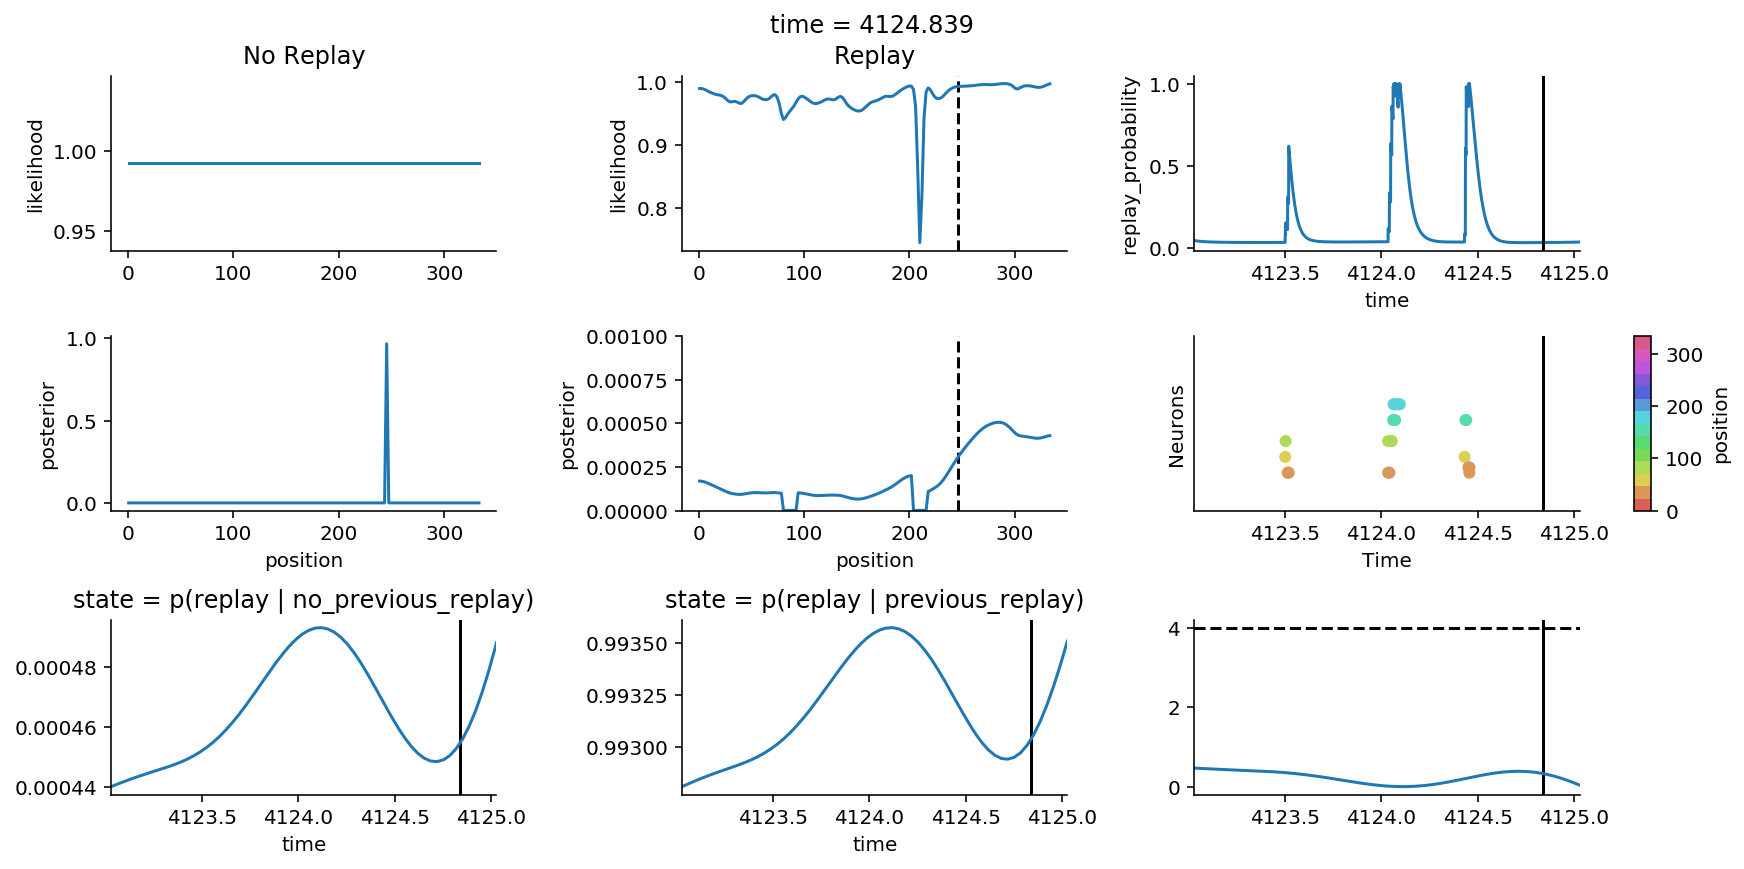

In [78]:
replay_number = 165

folder = 'temp3'
os.makedirs(folder, exist_ok=True)

offset = pd.Timedelta(1.000, 's')

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = data['spikes'].loc[start_time:end_time].index

speed = data['position_info'][speed_metric]
speed = np.asarray(speed).squeeze()
lagged_speed = lagmat(speed, maxlag=1).squeeze()
replay_state_transition = replay_detector.replay_state_transition_(lagged_speed)
replay_state_transition = xr.DataArray(
    replay_state_transition, dims=['time', 'state'],
    coords={'state': ['p(replay | no_previous_replay)', 'p(replay | previous_replay)'],
            'time': detector_results_no_smoother.time})

for ind, time in enumerate(tqdm(segment_time)):
    fig = plot_likelihood(time, start_time, end_time, detector_results_no_smoother,
                          replay_detector, data, replay_state_transition)
    figure_name = (f'temp_{ind:04d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)

In [21]:
speed = data['position_info'][speed_metric]
speed = np.asarray(speed).squeeze()
lagged_speed = lagmat(speed, maxlag=1).squeeze()
replay_state_transition = replay_detector.replay_state_transition_(lagged_speed)
replay_state_transition = xr.DataArray(
    replay_state_transition, dims=['time', 'state'],
    coords={'state': ['p(replay | no_previous_replay)', 'p(replay | previous_replay)'],
            'time': detector_results_no_smoother.time})
movement_state_transition = replay_detector.movement_state_transition_
place_bin_centers = replay_detector.place_bin_centers_
place_bin_edges = replay_detector.place_bin_edges_
detector_results_no_smoother

<xarray.Dataset>
Dimensions:             (position: 168, state: 2, time: 1396490)
Coordinates:
  * time                (time) timedelta64[ns] 01:02:09.025700 ... 01:17:40.018366
  * position            (position) float64 0.9942 2.983 4.971 ... 331.1 333.1
  * state               (state) <U9 'No Replay' 'Replay'
Data variables:
    replay_probability  (time) float64 0.0 0.0004867 ... 0.02461 0.02463
    posterior           (time, state, position) float64 0.0 0.0 ... 0.0002852
    likelihood          (time, state, position) float64 0.9786 0.9786 ... 0.9962

(0.0, 334.0679119249612)

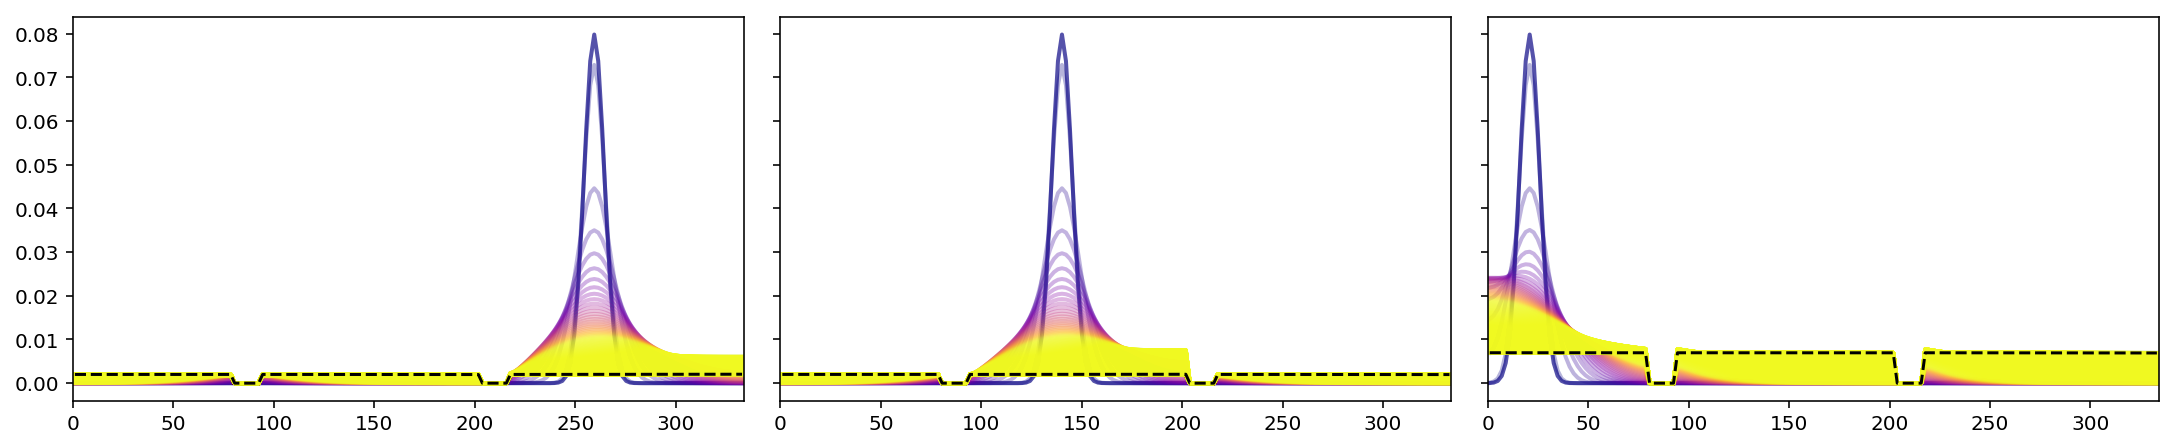

In [150]:
from scipy.stats import multivariate_normal

n_time = 10000
cmap = plt.cm.plasma(range(n_time))

fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True,
                         sharey=True, constrained_layout=True)

gaussian = multivariate_normal(mean=place_bin_centers[130], cov=25).pdf(place_bin_centers)
x = gaussian.copy()
axes[0].plot(place_bin_centers, x, color=cmap[0], linewidth=2, alpha=0.7)

for time_ind in np.arange(0, n_time):
    x = movement_state_transition @ x
    if (time_ind % 10) == 0:
        axes[0].plot(place_bin_centers, x, color=cmap[time_ind], linewidth=2, alpha=0.3)
axes[0].plot(place_bin_centers, x, color='black', linestyle='--')


gaussian = multivariate_normal(mean=place_bin_centers[70], cov=25).pdf(place_bin_centers)
x = gaussian.copy()
axes[1].plot(place_bin_centers, x, color=cmap[0], linewidth=2, alpha=0.7)

for time_ind in np.arange(0, n_time):
    x = movement_state_transition @ x
    if (time_ind % 10) == 0:
        axes[1].plot(place_bin_centers, x, color=cmap[time_ind], linewidth=2, alpha=0.3)
axes[1].plot(place_bin_centers, x, color='black', linestyle='--')

gaussian = multivariate_normal(mean=place_bin_centers[10], cov=25).pdf(place_bin_centers)
x = gaussian.copy()
axes[2].plot(place_bin_centers, x, color=cmap[0], linewidth=2, alpha=0.7)

for time_ind in np.arange(0, n_time):
    x = movement_state_transition @ x
    if (time_ind % 10) == 0:
        axes[2].plot(place_bin_centers, x, color=cmap[time_ind], linewidth=2, alpha=0.3)
axes[2].plot(place_bin_centers, x, color='black', linestyle='--')
axes[2].set_xlim((place_bin_edges.min(), place_bin_edges.max()));

In [151]:
offset = pd.Timedelta(1.100, 's')
replay_number = 267

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = detector_results_no_smoother.sel(time=slice(start_time, end_time)).time
segment_ind = np.nonzero(detector_results_no_smoother.time.isin(segment_time.time).values)[0]

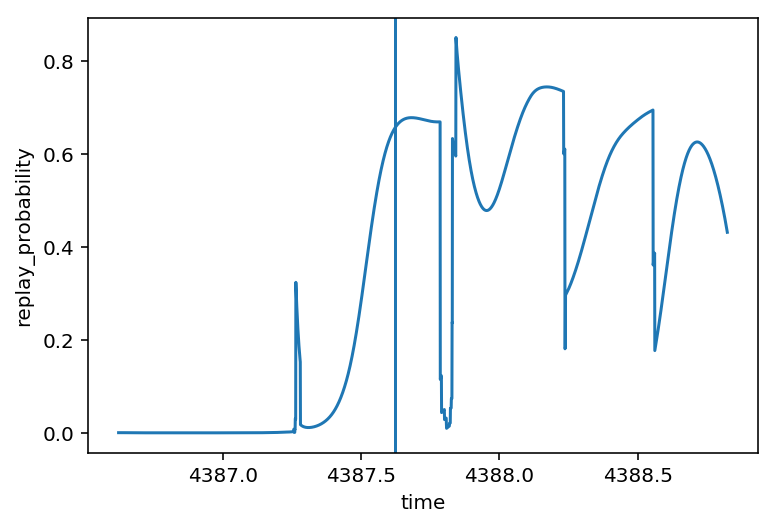

In [207]:
# 1000
# 1500
ind = 1500


(detector_results_no_smoother
 .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .isel(time=segment_ind[ind]).replay_probability)

(detector_results_no_smoother.sel(time=slice(start_time, end_time))
 .assign(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .replay_probability.plot(x='time'))
plt.axvline(detector_results_no_smoother.sel(time=segment_time[1500]).time.values / np.timedelta64(1, 's'))

In [ ]:
for k in np.arange(1, n_time):
    position_ind = observed_position_bin[k]
    # I_{k - 1} = 0, I_{k} = 0
    prior[k, 0, position_ind] = (
        (1 - replay_state_transition[k, 0]) * state_probability[k - 1, 0])
    # I_{k - 1} = 1, I_{k} = 0
    prior[k, 0, position_ind] += (
        (1 - replay_state_transition[k, 1]) * state_probability[k - 1, 1])

    # I_{k - 1} = 0, I_{k} = 1
    prior[k, 1] = (replay_state_transition[k, 0] * uniform *
                   state_probability[k - 1, 0])
    # I_{k - 1} = 1, I_{k} = 1
    prior[k, 1] += (
        replay_state_transition[k, 1] *
        (movement_state_transition @ posterior[k - 1, 1]))

    posterior[k] = normalize_to_probability(
        prior[k] * likelihood[k])

    state_probability[k] = np.sum(posterior[k], axis=1)

Text(0.5, 1.0, 'Combined')

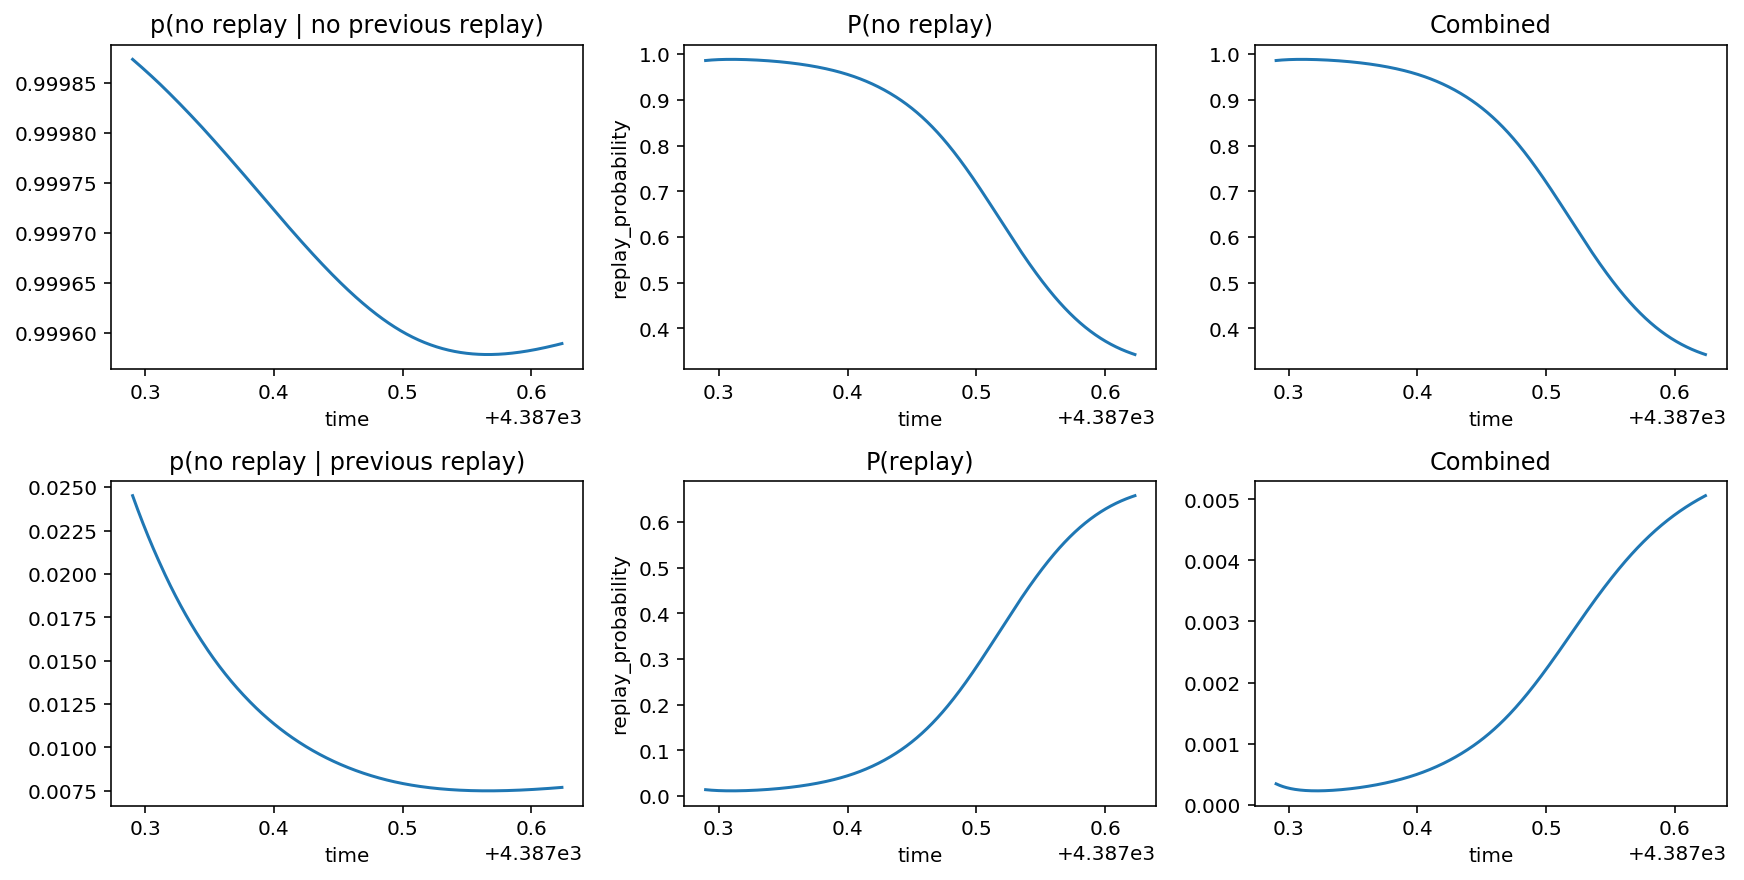

In [250]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(12, 6))

(1 - (replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=0)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[0, 0])
axes[0, 0].set_title('p(no replay | no previous replay)')

(1 - (detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[0, 1])
axes[0, 1].set_title('P(no replay)')

((1 - (replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=0)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)) *(1 - (detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's')).values
))).plot(x='time', ax=axes[0, 2])
axes[0, 2].set_title('Combined')

(1 - (replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=1)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[1, 0])
axes[1, 0].set_title('p(no replay | previous replay)')

((detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[1, 1])
axes[1, 1].set_title('P(replay)')


((1 - (replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=1)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)) *((detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's')).values
))).plot(x='time', ax=axes[1, 2])
axes[1, 2].set_title('Combined')

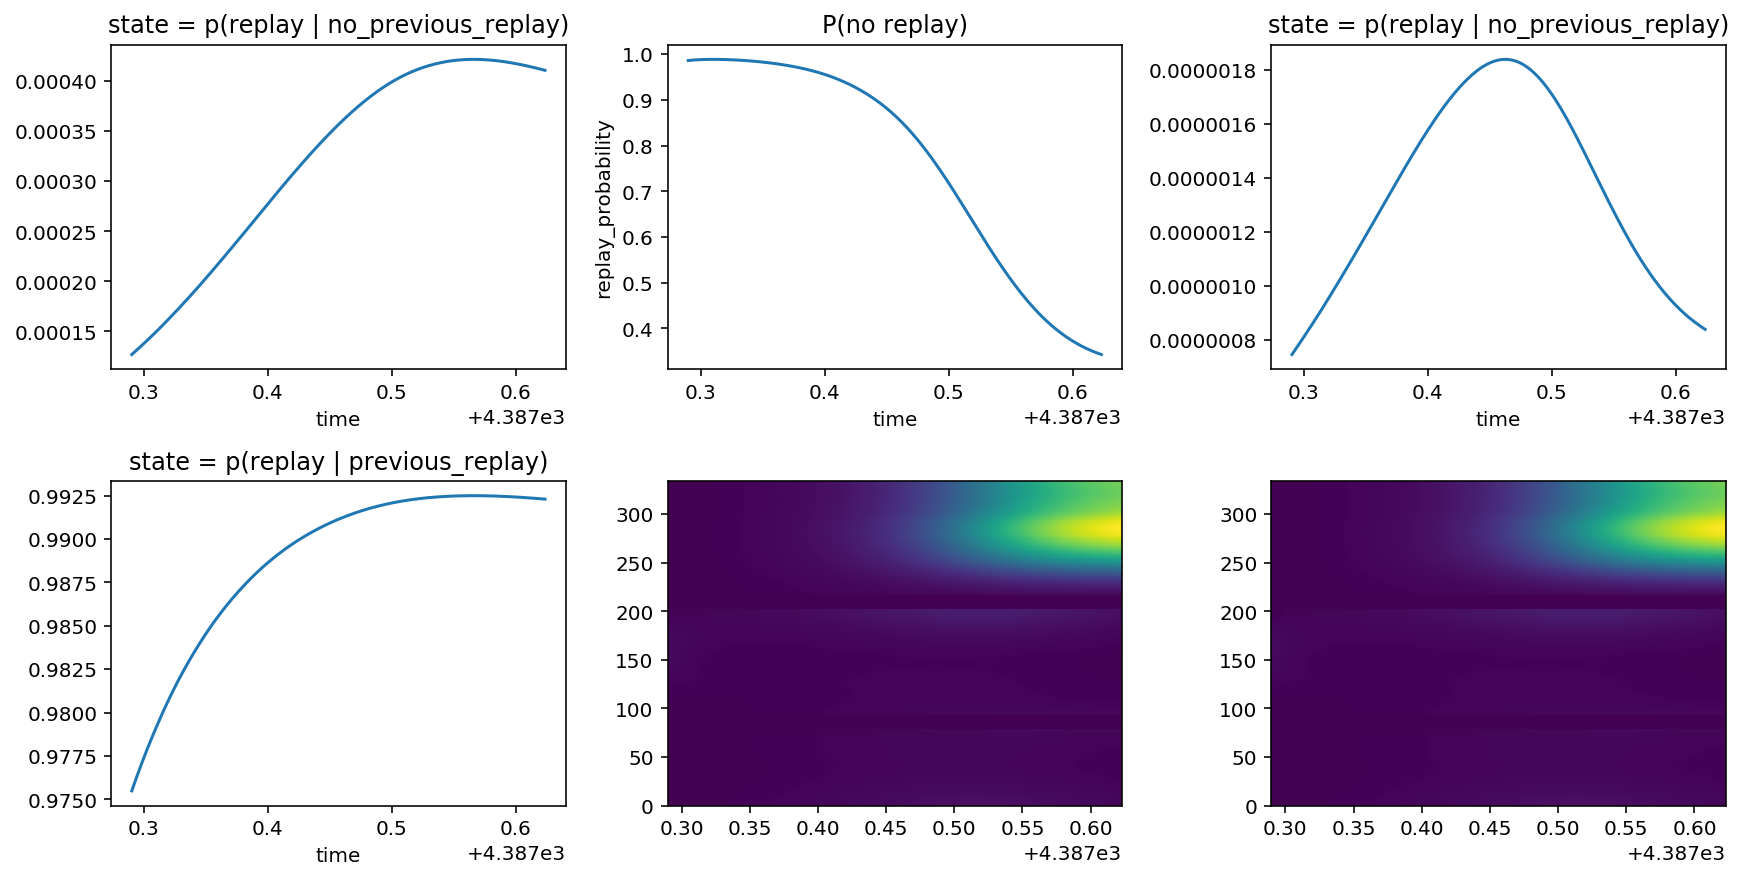

In [295]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(12, 6))

n_position_bins = place_bin_centers.size
uniform = 1 / n_position_bins

((replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=0)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[0, 0])

((1 -(detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)) ).plot(x='time', ax=axes[0, 1])
axes[0, 1].set_title('P(no replay)')


prior2 = (((replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=0)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)) * ((1 -(detector_results_no_smoother
 .replay_probability
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).values * uniform))

prior2.plot(x='time', ax=axes[0, 2])


((replay_state_transition
 .sel(time=slice(segment_time[1000], segment_time[1500]))
 .isel(state=1)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
)).plot(x='time', ax=axes[1, 0])

prior = (movement_state_transition @ (detector_results_no_smoother.posterior
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .isel(state=1).T
)).T

t = (detector_results_no_smoother.posterior
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's')).time.values)

x, y = np.meshgrid(t, place_bin_edges)
axes[1, 1].pcolormesh(x, y, prior.T)

axes[1, 2].pcolormesh(x, y, prior.T + prior2.values)

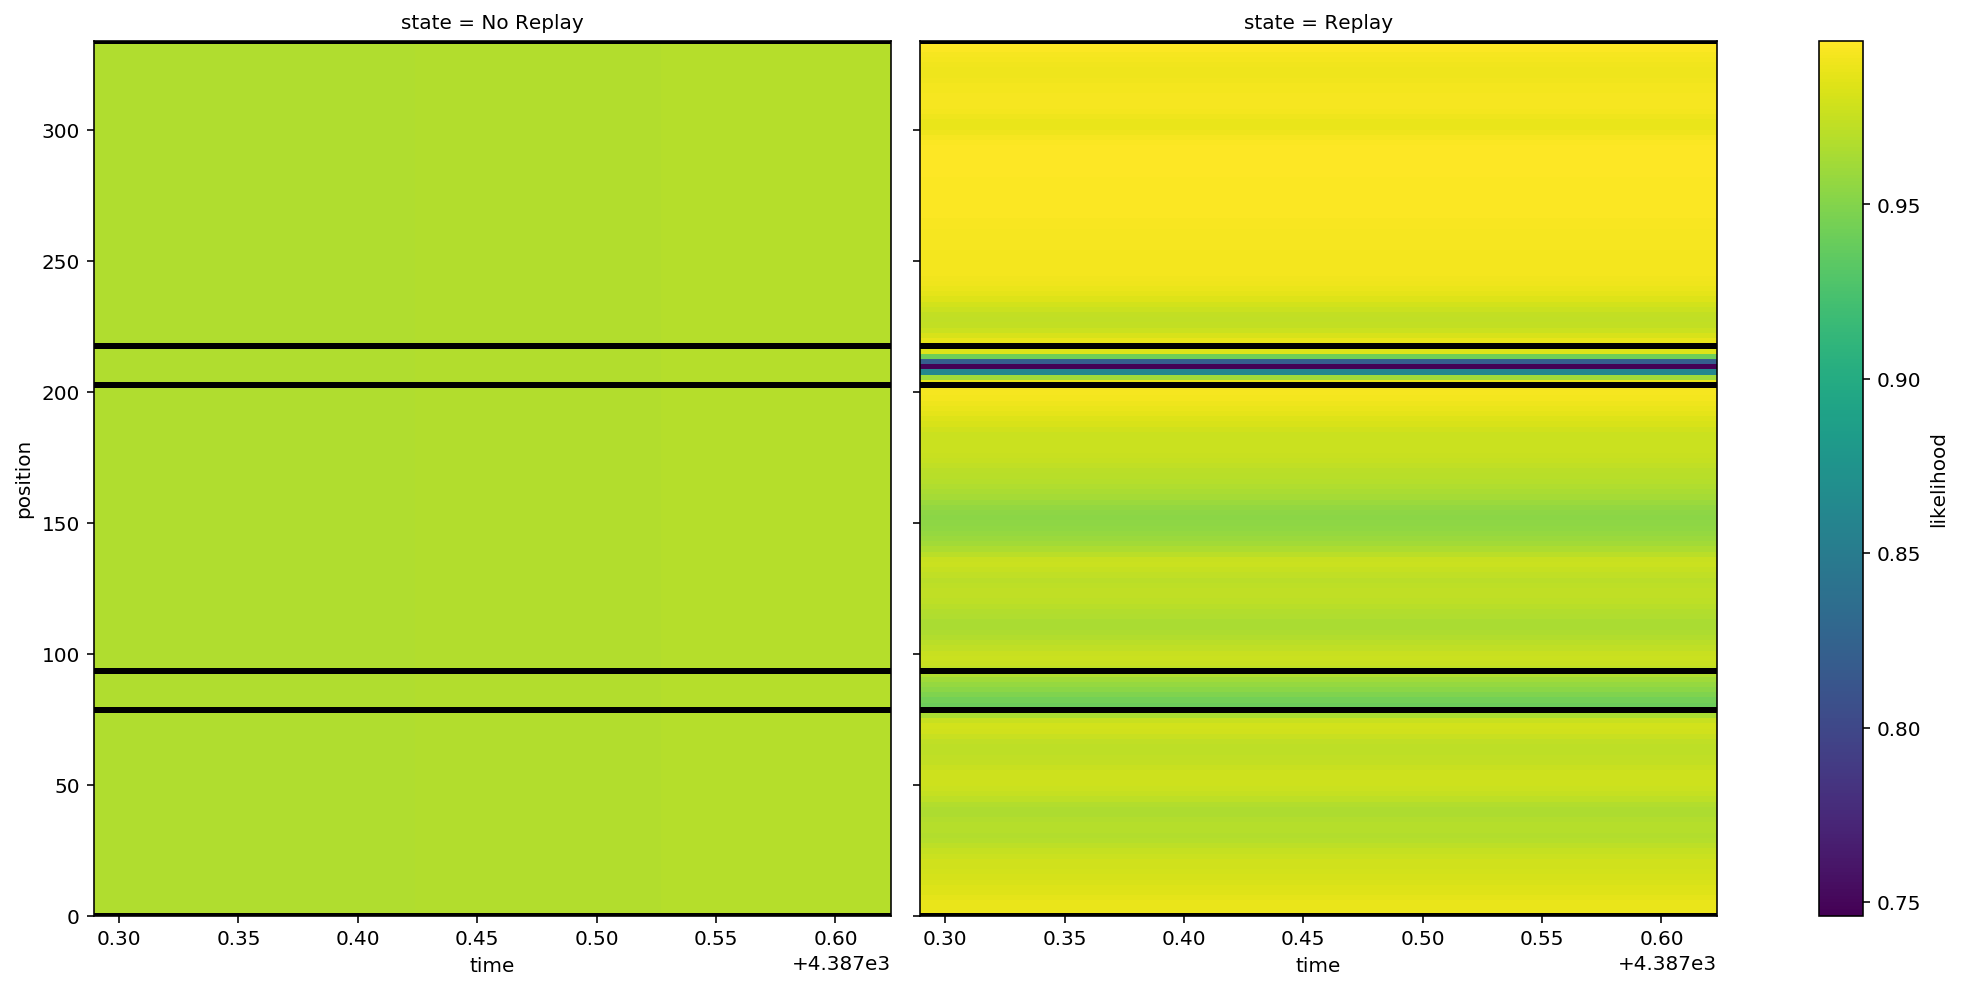

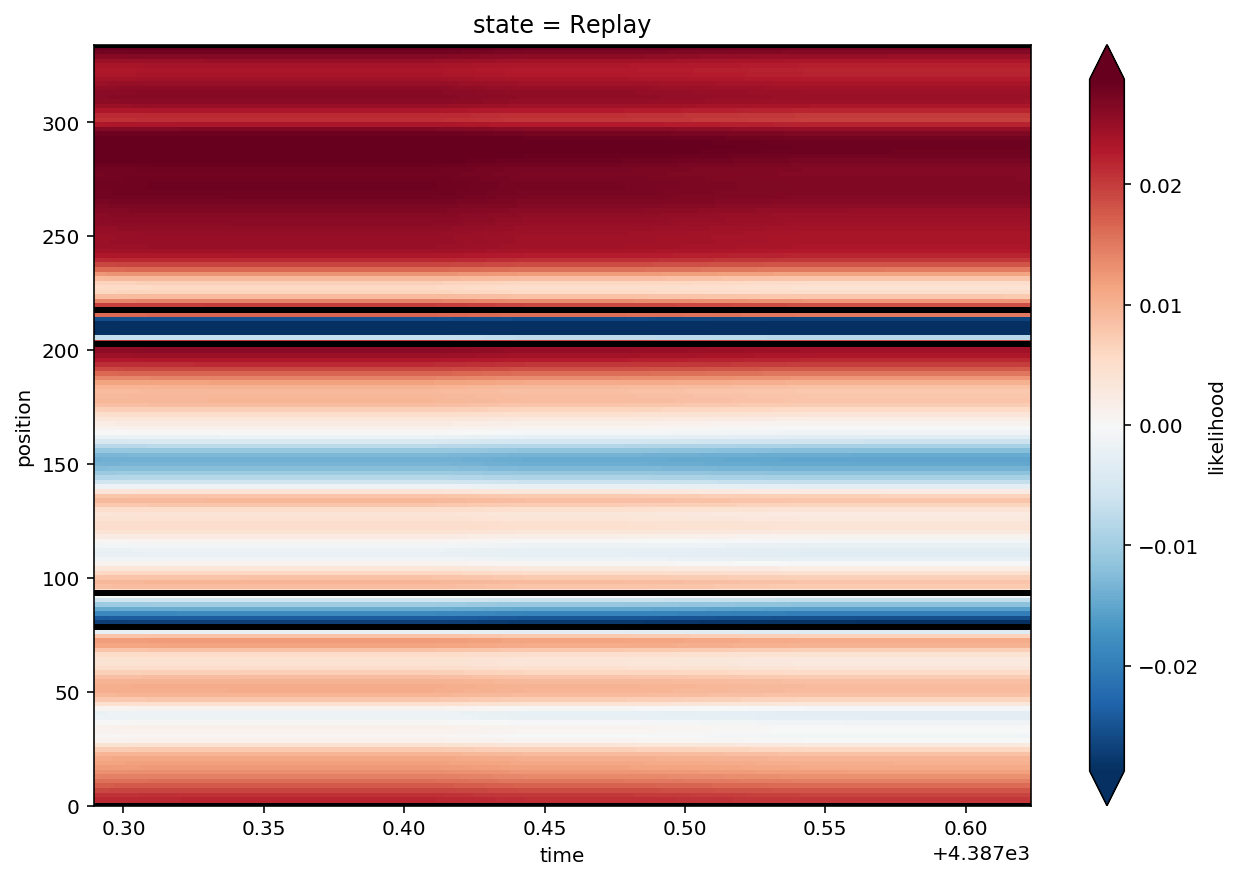

In [307]:
h = (detector_results_no_smoother.likelihood
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
).plot(x='time', y='position', col='state', size=7)

position_info = data['position_info']

max_df = (position_info
          .groupby('arm_name')[position_metric].max())

for ax in h.axes.flat:
    for arm_name, max_position in max_df.iteritems():
        ax.axhline(max_position, color='black',
                   linestyle='-', linewidth=3)
    min_df = (position_info
              .groupby('arm_name')[position_metric].min())
    for arm_name, min_position in min_df.iteritems():
        ax.axhline(min_position, color='black',
                   linestyle='-', linewidth=3)


h = (detector_results_no_smoother.likelihood
 .sel(time=slice(segment_time[1000 - 1], segment_time[1500 - 1]))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .diff('state')
).plot(x='time', y='position', size=7, robust=True)

position_info = data['position_info']

max_df = (position_info
          .groupby('arm_name')[position_metric].max())

for arm_name, max_position in max_df.iteritems():
    h.axes.axhline(max_position, color='black',
               linestyle='-', linewidth=3)
min_df = (position_info
          .groupby('arm_name')[position_metric].min())
for arm_name, min_position in min_df.iteritems():
    h.axes.axhline(min_position, color='black',
               linestyle='-', linewidth=3)

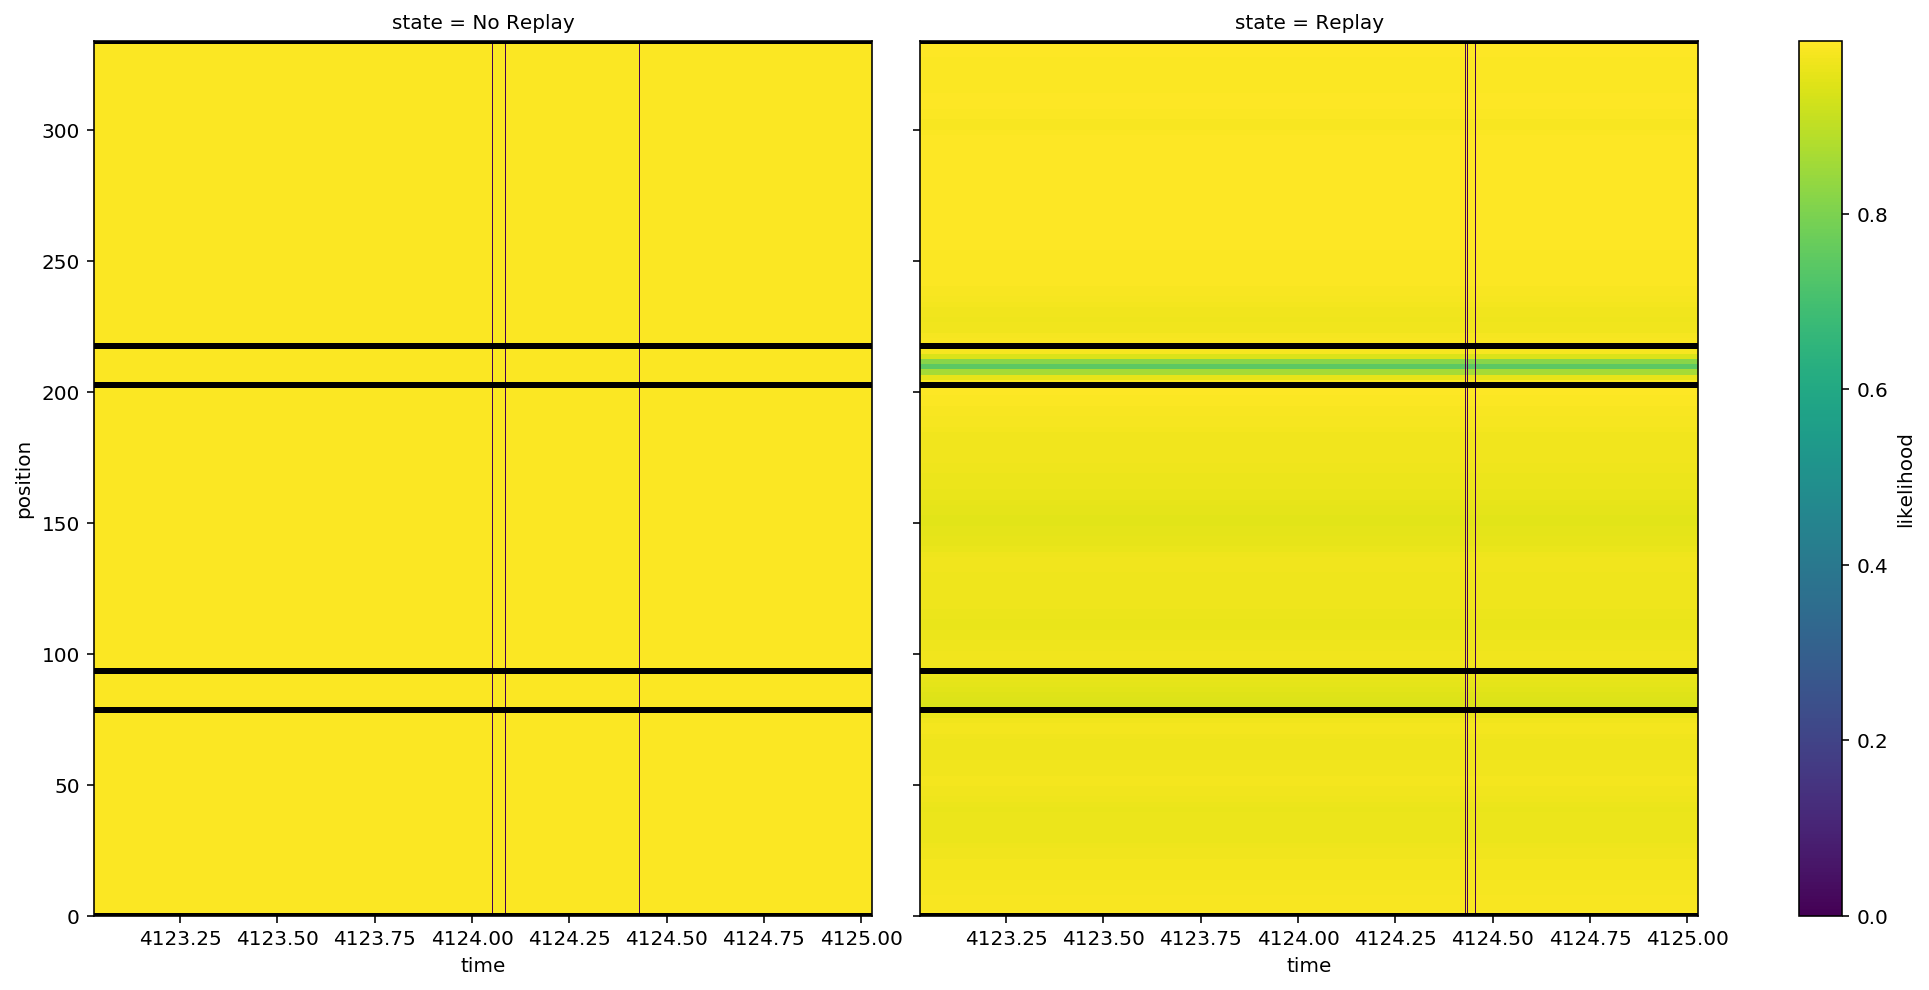

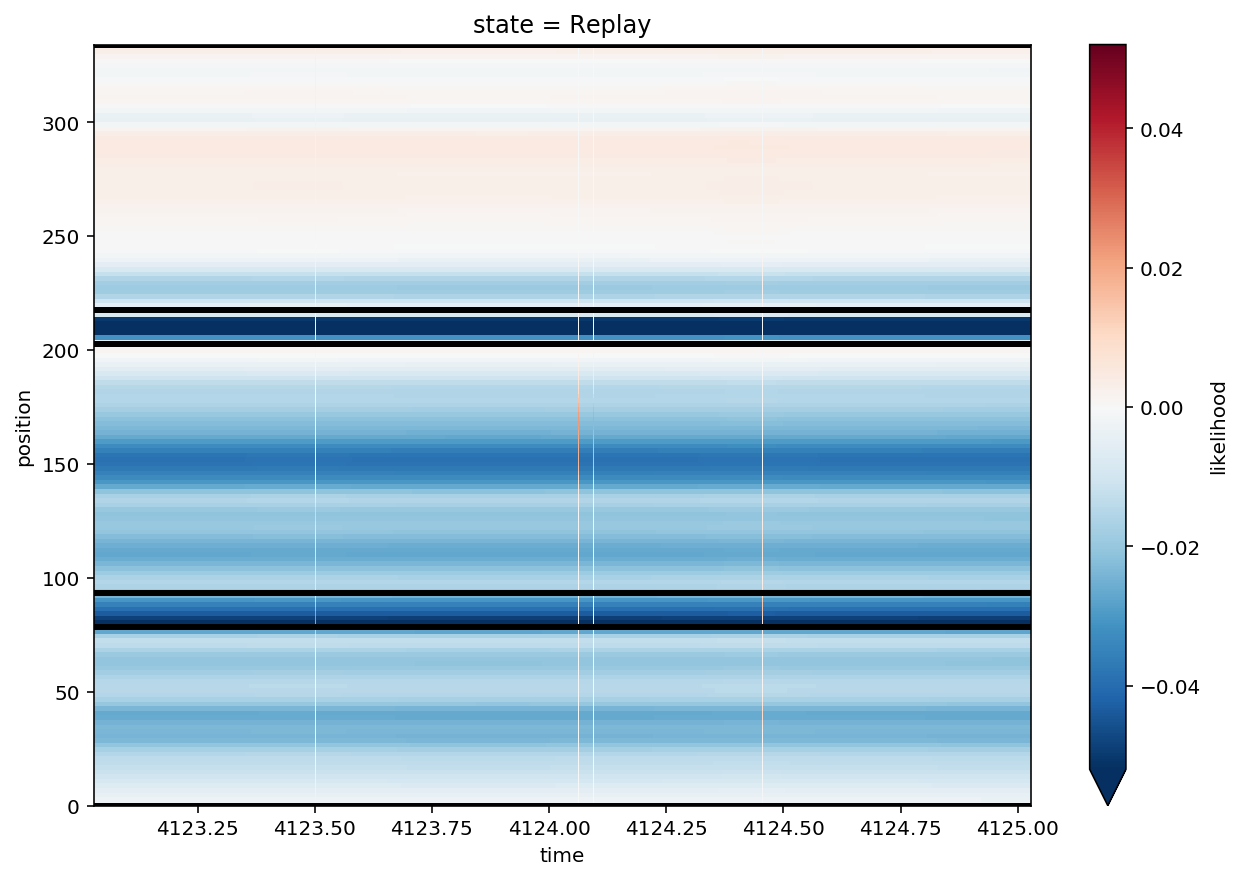

In [315]:
replay_number = 165

offset = pd.Timedelta(1.000, 's')

start_time = data['ripple_times'].loc[replay_number].start_time - offset 
end_time = data['ripple_times'].loc[replay_number].start_time + offset 

segment_time = data['spikes'].loc[start_time:end_time].index


h = (detector_results_no_smoother.likelihood
 .sel(time=slice(start_time, end_time))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
).plot(x='time', y='position', col='state', size=7)

position_info = data['position_info']

max_df = (position_info
          .groupby('arm_name')[position_metric].max())

for ax in h.axes.flat:
    for arm_name, max_position in max_df.iteritems():
        ax.axhline(max_position, color='black',
                   linestyle='-', linewidth=3)
    min_df = (position_info
              .groupby('arm_name')[position_metric].min())
    for arm_name, min_position in min_df.iteritems():
        ax.axhline(min_position, color='black',
                   linestyle='-', linewidth=3)


h = (detector_results_no_smoother.likelihood
 .sel(time=slice(start_time, end_time))
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .diff('state')
).plot(x='time', y='position', size=7, robust=True)

position_info = data['position_info']

max_df = (position_info
          .groupby('arm_name')[position_metric].max())

for arm_name, max_position in max_df.iteritems():
    h.axes.axhline(max_position, color='black',
               linestyle='-', linewidth=3)
min_df = (position_info
          .groupby('arm_name')[position_metric].min())
for arm_name, min_position in min_df.iteritems():
    h.axes.axhline(min_position, color='black',
               linestyle='-', linewidth=3)

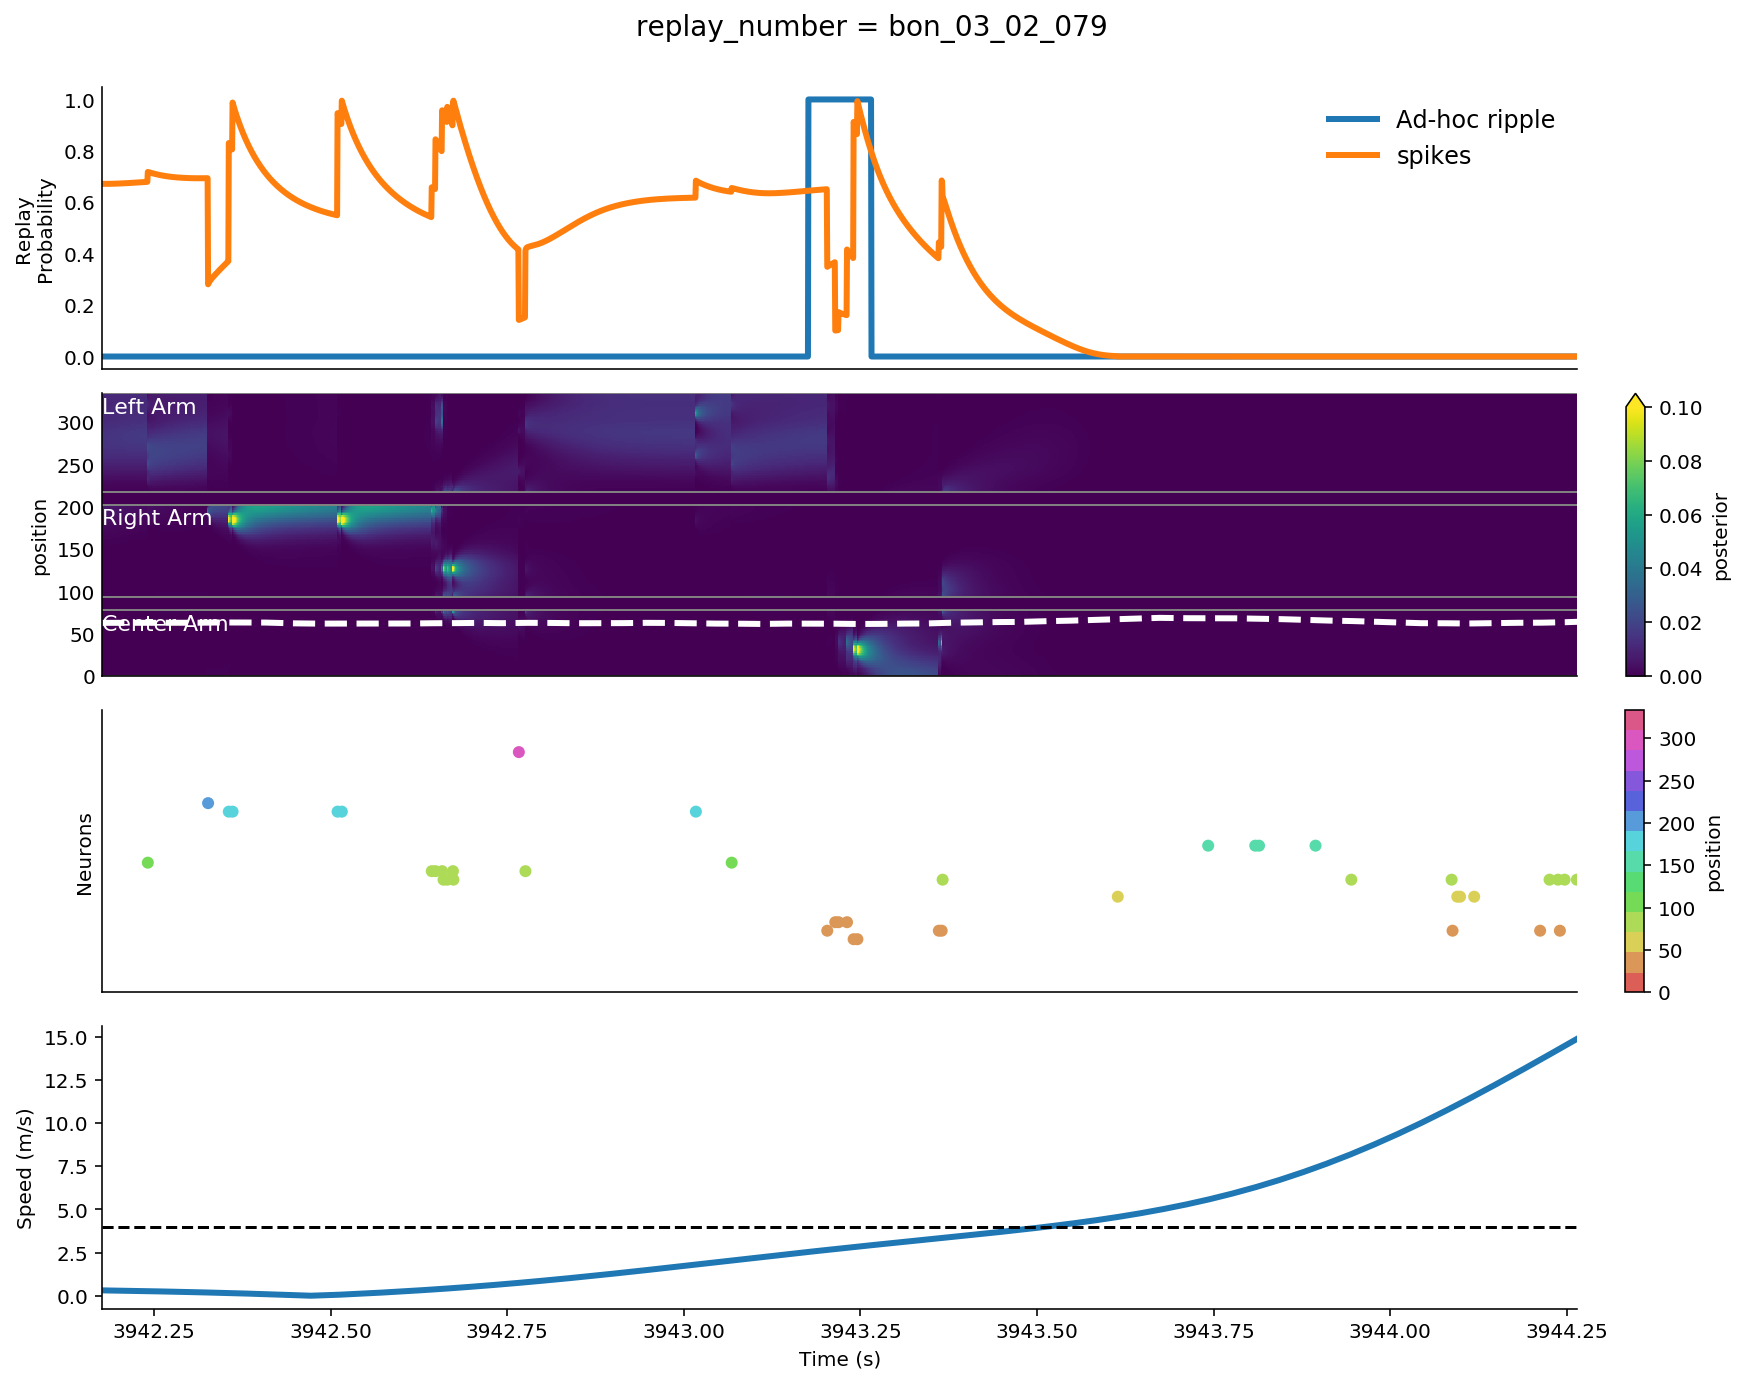

In [400]:
replay_number = 79

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric,
                      offset=pd.Timedelta(1.000, 's'));

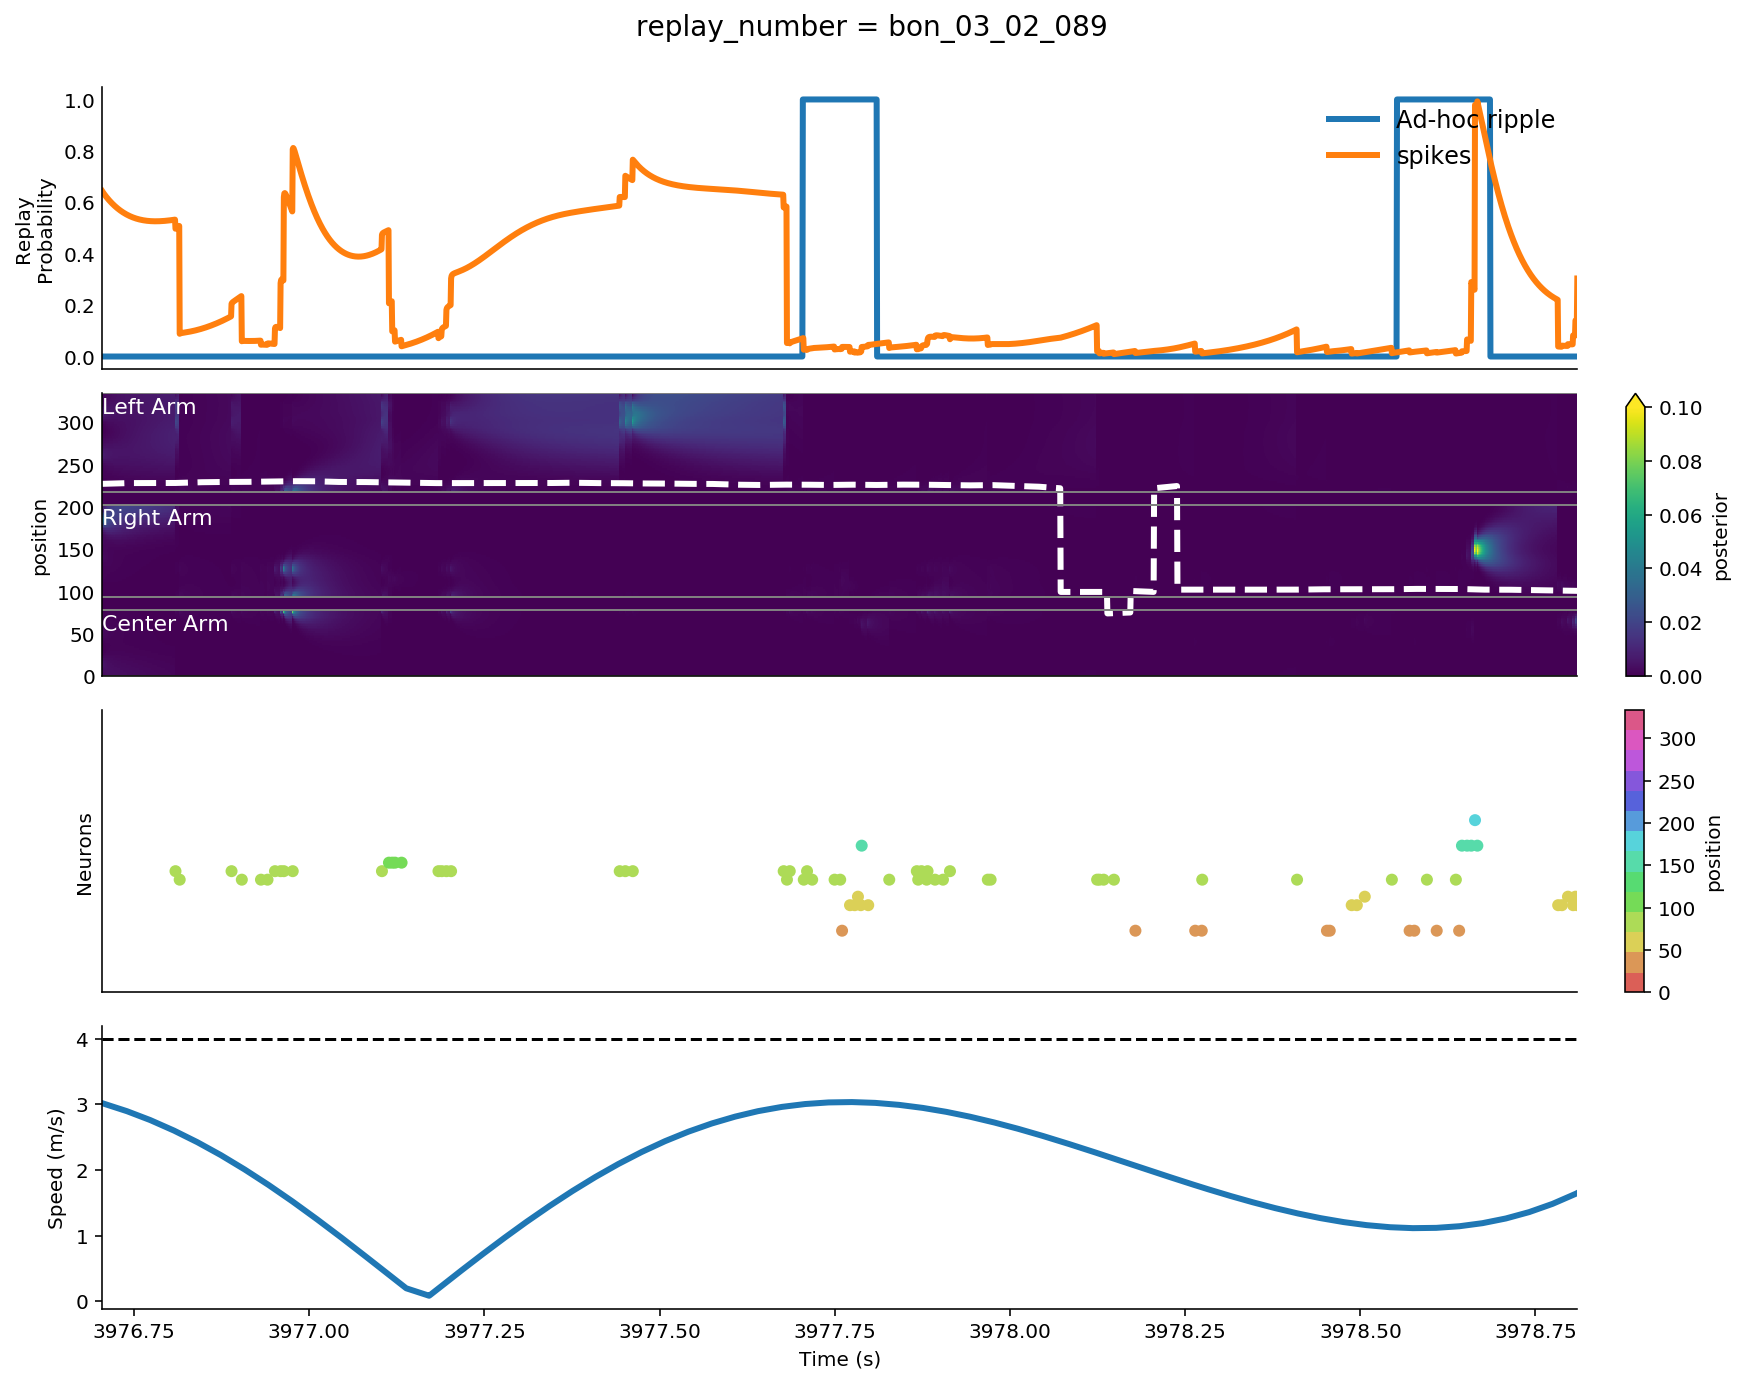

In [410]:
replay_number = 89

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric,
                      offset=pd.Timedelta(1.000, 's'));

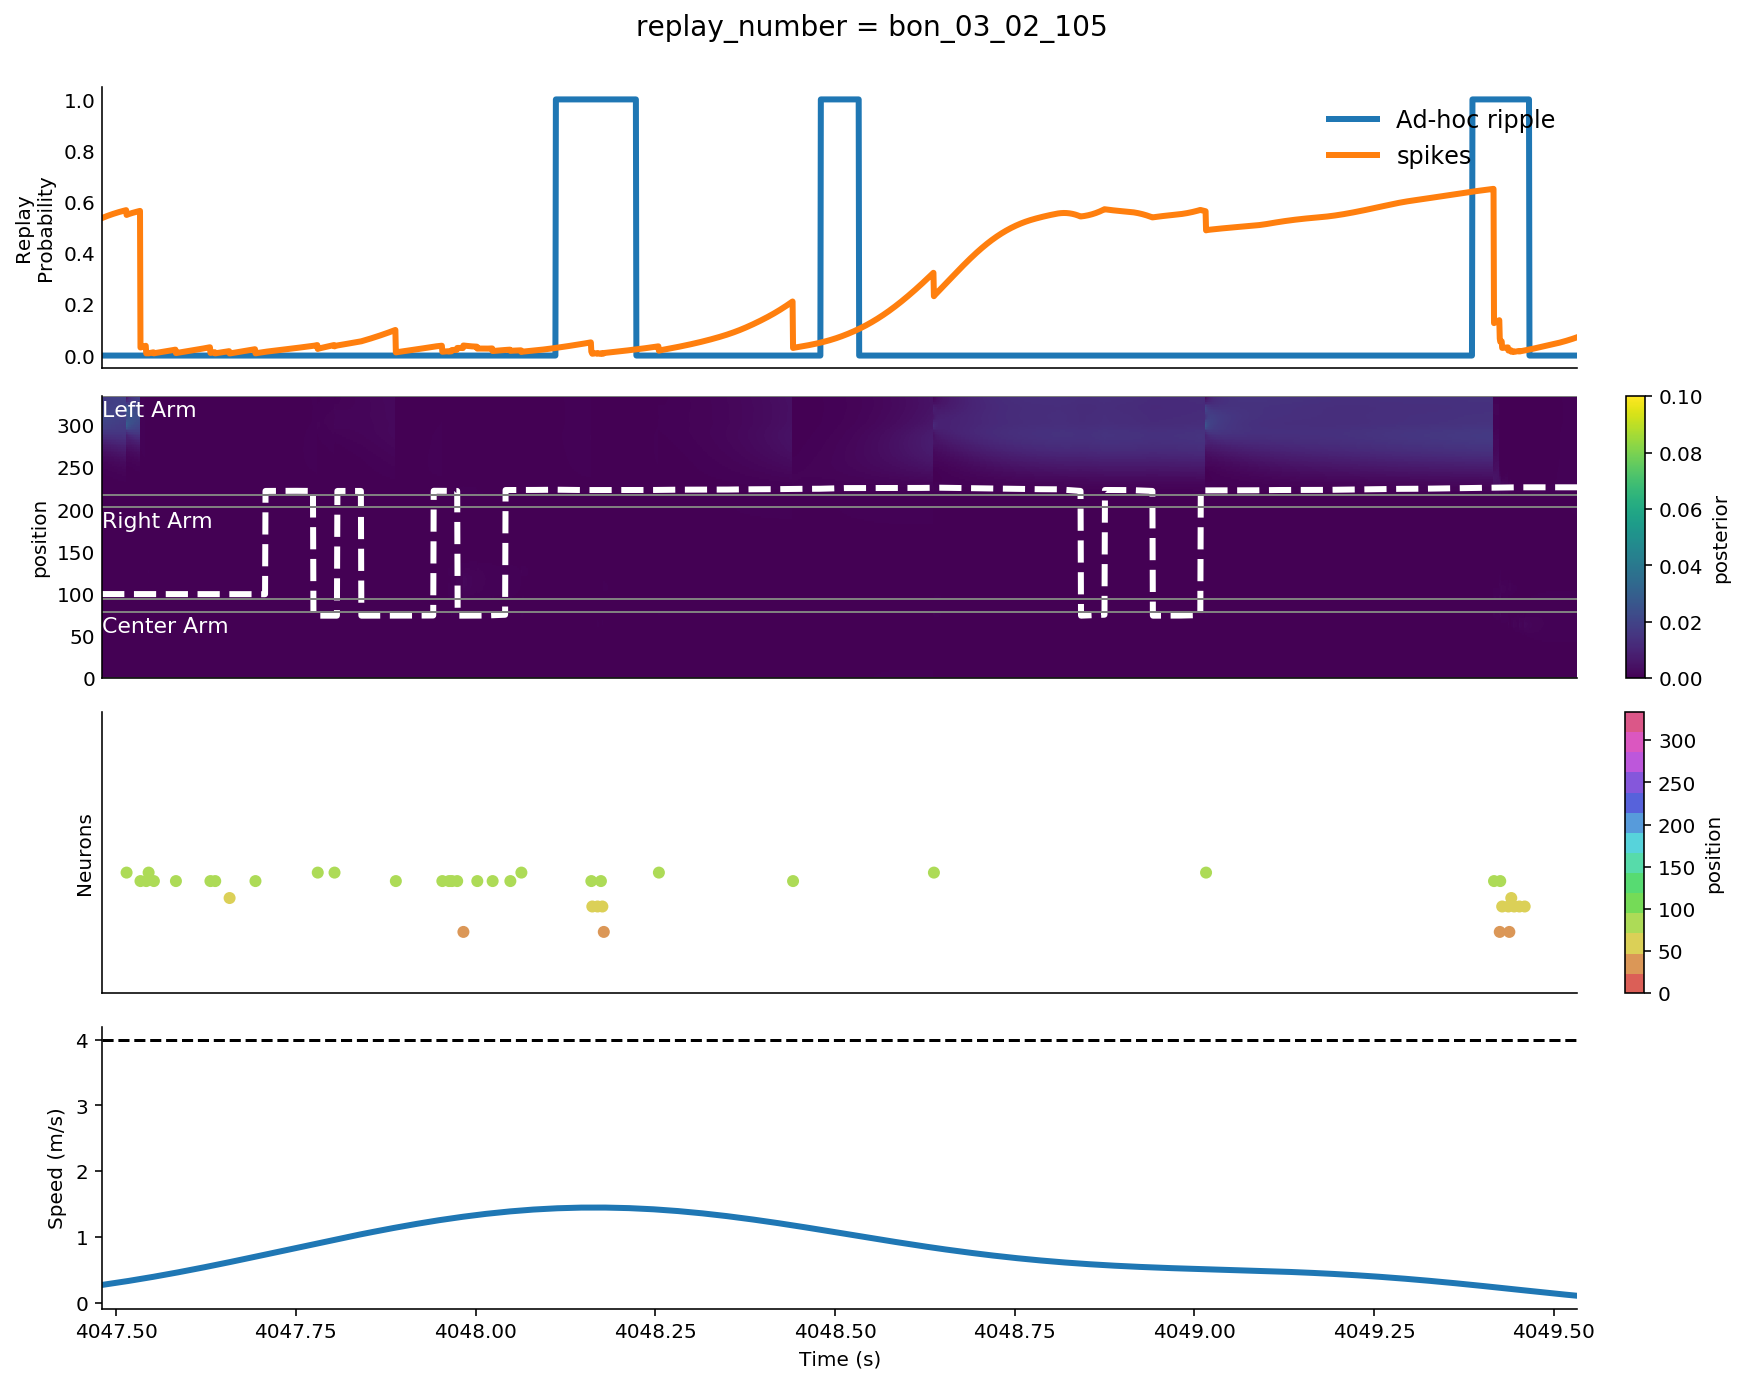

In [428]:
replay_number = 105

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric,
                      offset=pd.Timedelta(1.000, 's'));

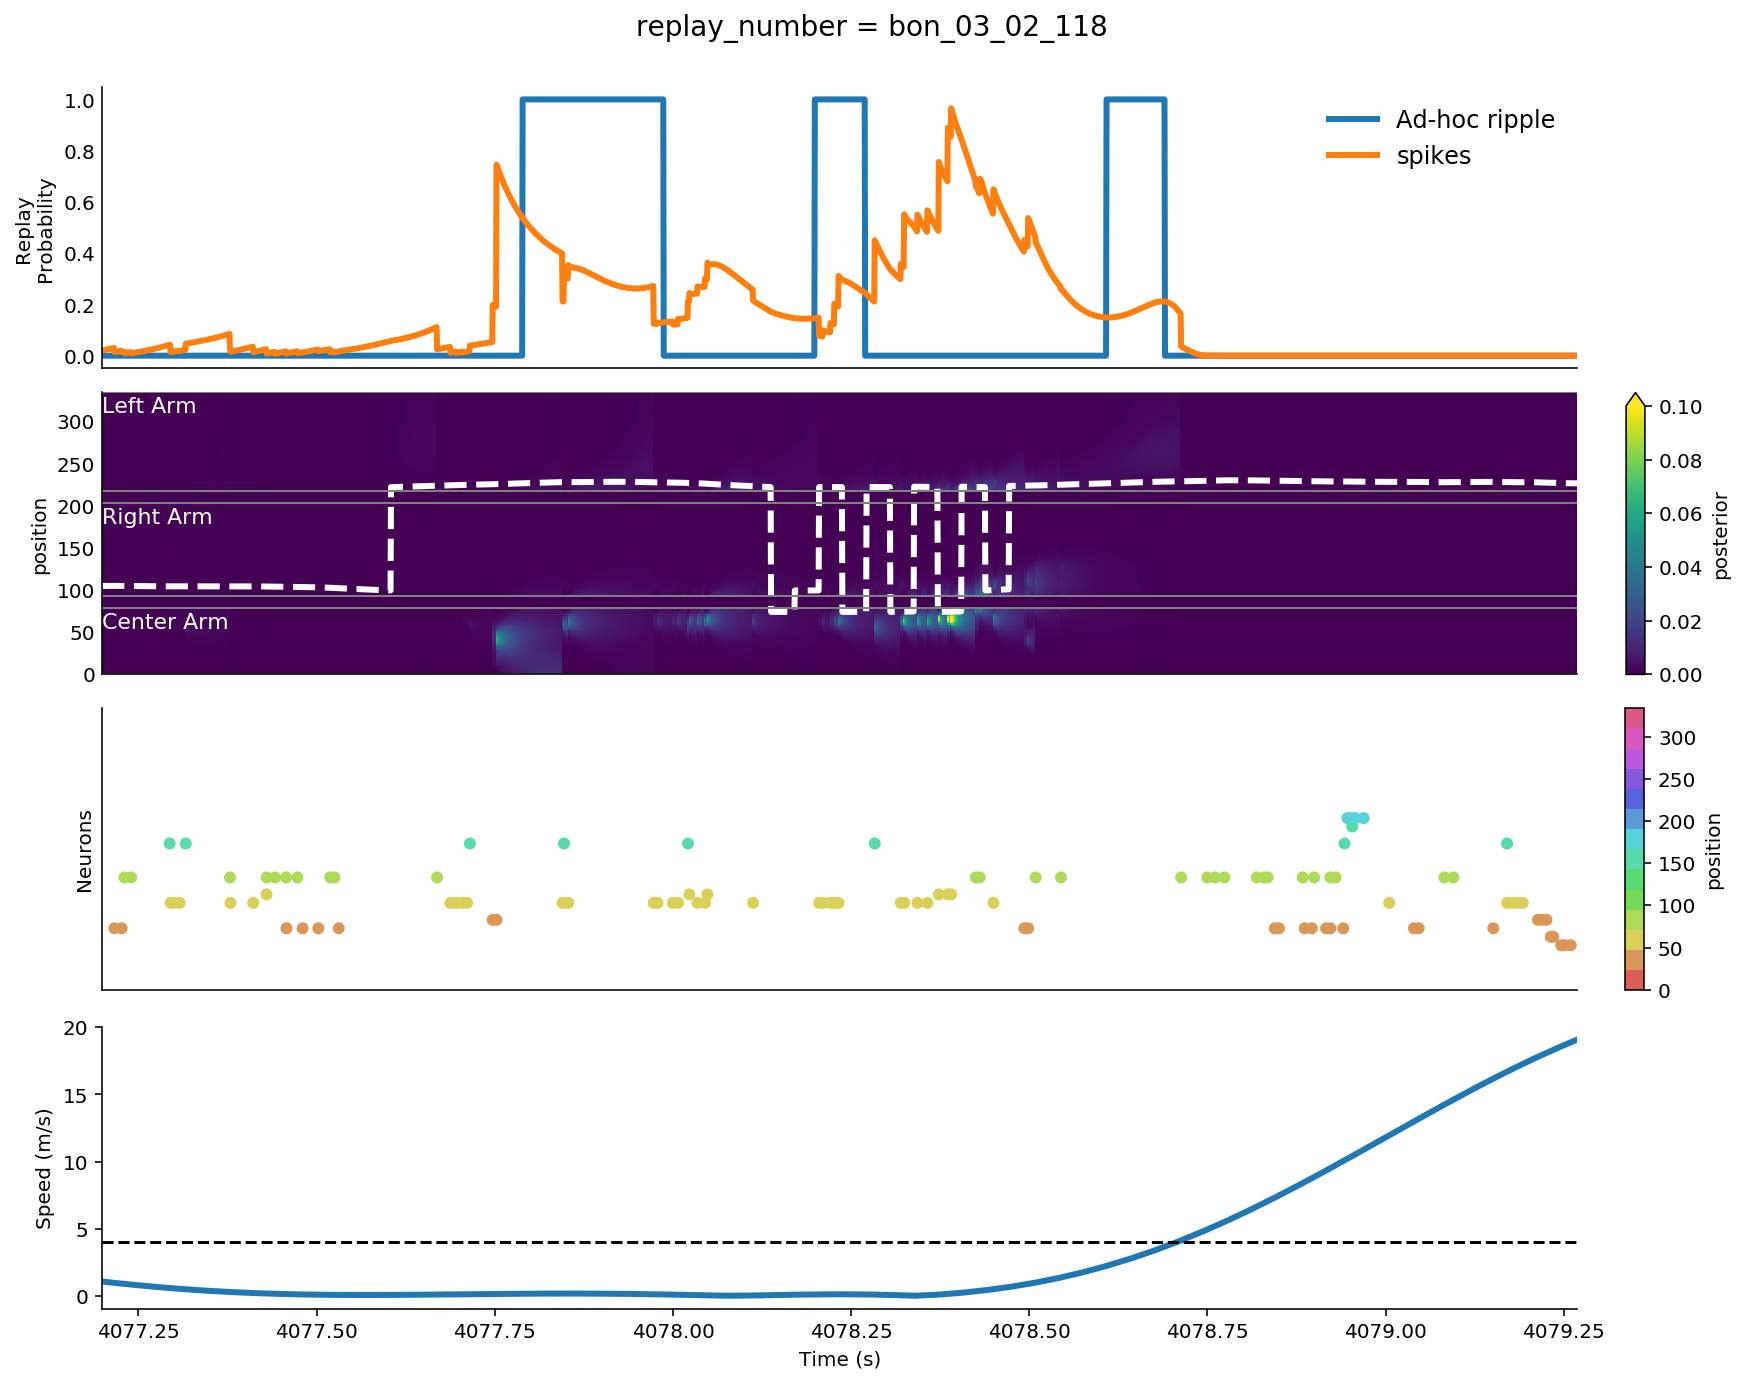

In [441]:
replay_number = 118

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric,
                      offset=pd.Timedelta(1.000, 's'));

In [1]:
replay_number = 131

plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                      replay_detector, spikes_detector_results=detector_results_no_smoother,
                      show_data_types=['spikes', 'speed'],
                      show_result_types=['ad_hoc_ripple', 'spikes'],
                      position_metric=position_metric,
                      offset=pd.Timedelta(1.000, 's'));

NameError: name 'plot_replay_with_data' is not defined

In [16]:
import os
from src.visualization import plot_replay_with_data
from src.parameters import FIGURE_DIR
from tqdm.autonotebook import tqdm

animal, day, epoch = epoch_key
data_source = 'ad_hoc_ripple'
smoother_type = 'filter'

folder = os.path.join(FIGURE_DIR, f'replays_{data_source}_{smoother_type}')
os.makedirs(folder, exist_ok=True)

for replay_number in tqdm(data['ripple_times'].index):
    fig, _ = plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                          replay_detector, spikes_detector_results=detector_results_no_smoother,
                          show_data_types=['spikes', 'speed'],
                          show_result_types=['ad_hoc_ripple', 'spikes'],
                          position_metric=position_metric,
                          offset=pd.Timedelta(0.500, 's'))
    figure_name = (
        f'{animal}_{day:02d}_{epoch:02d}_{replay_number:03d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)


In [17]:
import os
from src.visualization import plot_replay_with_data
from src.parameters import FIGURE_DIR
from tqdm.autonotebook import tqdm

animal, day, epoch = epoch_key
data_source = 'ad_hoc_ripple'
smoother_type = 'smoother'

folder = os.path.join(FIGURE_DIR, f'replays_{data_source}_{smoother_type}')
os.makedirs(folder, exist_ok=True)

for replay_number in tqdm(data['ripple_times'].index):
    fig, _ = plot_replay_with_data(replay_number, data, data['ripple_times'], epoch_key,
                          replay_detector, spikes_detector_results=detector_results,
                          show_data_types=['spikes', 'speed'],
                          show_result_types=['ad_hoc_ripple', 'spikes'],
                          position_metric=position_metric,
                          offset=pd.Timedelta(0.500, 's'))
    figure_name = (
        f'{animal}_{day:02d}_{epoch:02d}_{replay_number:03d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
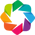

In [19]:
from src.summarize_replay import get_replay_times

spikes_replay_info, spikes_is_replay = get_replay_times(
    detector_results)

In [21]:
import os
from src.visualization import plot_replay_with_data
from src.parameters import FIGURE_DIR
from tqdm.autonotebook import tqdm

animal, day, epoch = epoch_key
data_source = 'spikes'
smoother_type = 'smoother'

folder = os.path.join(FIGURE_DIR, f'replays_{data_source}_{smoother_type}')
os.makedirs(folder, exist_ok=True)

for replay_number in tqdm(spikes_replay_info.index):
    fig, _ = plot_replay_with_data(replay_number, data, spikes_replay_info, epoch_key,
                          replay_detector, spikes_detector_results=detector_results,
                          show_data_types=['spikes', 'speed'],
                          show_result_types=['ad_hoc_ripple', 'spikes'],
                          position_metric=position_metric,
                          offset=pd.Timedelta(0.500, 's'))
    figure_name = (
        f'{animal}_{day:02d}_{epoch:02d}_{replay_number:03d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)


In [22]:
import os
from src.visualization import plot_replay_with_data
from src.parameters import FIGURE_DIR
from tqdm.autonotebook import tqdm

animal, day, epoch = epoch_key
data_source = 'spikes'
smoother_type = 'filter'

folder = os.path.join(FIGURE_DIR, f'replays_{data_source}_{smoother_type}')
os.makedirs(folder, exist_ok=True)

for replay_number in tqdm(spikes_replay_info.index):
    fig, _ = plot_replay_with_data(replay_number, data, spikes_replay_info, epoch_key,
                          replay_detector, spikes_detector_results=detector_results_no_smoother,
                          show_data_types=['spikes', 'speed'],
                          show_result_types=['ad_hoc_ripple', 'spikes'],
                          position_metric=position_metric,
                          offset=pd.Timedelta(0.500, 's'))
    figure_name = (
        f'{animal}_{day:02d}_{epoch:02d}_{replay_number:03d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(fig)
